# Exploring the bias/variance trade-off with a simple classification example

**Aim:** Perform binary classification on 2-D simulated data, using:
1. Polynomial model,
2. Fully connected neural network model.

Starting with polynomial model, we wish to peform the following experiments: 
1. Model capacity (polynomial degree or depth/width) vs. test/training error of trained model
2. Regularisation parameter vs. test/training error of trained model
3. How does the minimum of the test error curve (x-axis = capacity or regularisation) change with increasing noise?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

## Simulated dataset

The predictor variables $\{x_i\}$ of the data shall be drawn from a uniform probability distribution on $[-2,2]^2$. 

We shall randomly generate a polynomial $f: \mathbb{R}^2 \to \mathbb{R}$ of degree $N$. Specifically, the coefficients shall be drawn from a normal distribution.

The target variables of the data shall be given by 
$$ y_i = \begin{cases}1 & \text{if }  f(x_i + e_i) \geq 0\\
0 & \text{if } f(x_i + e_i) < 0
\end{cases}$$
where $e_i$ are drawn from the probability distribution $\mathcal{N}(0,s)$ for some $s > 0$ which we shall refer to as the *noise strength*.


First we define a function generating the dataset as numpy arrays `x_arr` and `y_arr`. The following cell will fix the function f.

In [2]:
N = 6
s = 0.2
f_sd = 0.5 #  Standard deviation in coefficients of model

f_coeff = np.random.normal(scale = 0.5, size= (N+1,N+1))
def f(x,f_coeff = f_coeff):
    tmp = 0
    for i in range(N+1):
        for j in range(N+1):
            if i + j <= N: tmp += f_coeff[i,j]*(x[0]**i)*(x[1]**j)
    return tmp

def give_arr_data(dataset_size, N = N, s = s, f = f):
    '''
    Gives array of predictor variables x_arr and array of traget variables y_arr
    '''
    x_arr = np.random.uniform(low = -2, high = 2, size = (dataset_size,2)) # Predictor variables
    y_arr = []
    for x in x_arr:
        e = np.random.normal(scale = s, size = (2,))
        if f(x + e) >= 0: y_arr.append([1])
        else: y_arr.append([0])
    y_arr = np.array(y_arr) # Target variables
    return x_arr, y_arr

Plotting the data.

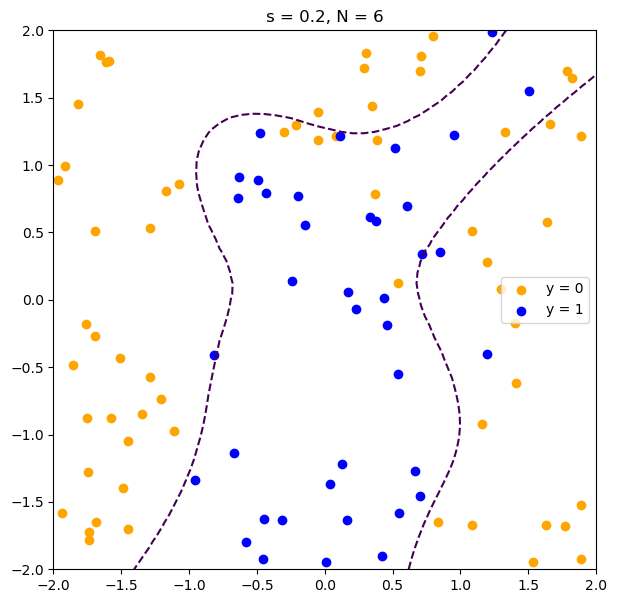

In [3]:
x_arr, y_arr = give_arr_data(dataset_size = 100)

x_arr_0 = [] 
x_arr_1 = [] 
for i in range(len(x_arr)):
    if y_arr[i][0] == 0: x_arr_0.append(x_arr[i])
    else: x_arr_1.append(x_arr[i])
x_arr_0 = np.array(x_arr_0) # x_i such that y_i = 0
x_arr_1 = np.array(x_arr_1) # x_i such that y_i = 1

fig, ax = plt.subplots(1,1,figsize = (7,7))
if len(x_arr_0) > 0:  ax.scatter(x_arr_0.transpose()[0],x_arr_0.transpose()[1],color = 'orange', label = 'y = 0')
if len(x_arr_1) > 0: ax.scatter(x_arr_1.transpose()[0],x_arr_1.transpose()[1],color = 'blue', label = 'y = 1')
ax.legend()
ax.set_xlim((-2,2))
ax.set_ylim((-2,2))
# Level set
X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
Z = np.zeros((len(X0),len(X1)))
for i in range(50):
    for j in range(50):
        Z[i,j] = f([X0[i,j],X1[i,j]])
ax.contour(X0,X1,Z, levels =[0], linestyles = '--')
ax.title.set_text(f's = {s}, N = {N}')
plt.show()


## Polynomial classification w/o regularisation

In this section, we perform polynomial classification procedure for the probability distibution defined by $f$ above (a different realisation of the data is used).

Polynomial regression reduces to linear regression by the application of the transformation,
$$x \in \mathbb{R}^2 \mapsto \tilde{x} = (x_0^ix_1^j: 1 \leq i  + j \leq M)$$
to each predictor variable $x$ in the dataset. 


In [4]:
def x_to_xx(x_ts,M):
    '''
    Given torch tensor input in the form [x_0,x_1,x_2,...] where x_j is a (2,) tensor for each j, 
    returns [xx_0,xx_1,xx_2,...] where, for each j, xxj is a 1d tensor whose elements const of all non-constant monomials 
    of variables x_j[0] and x_j[1] with at most degree M (e.g.  for M = 2 elements are x_j[0], x_j[1], x_j[0]**2, x_j[1]**2, x_j[0]*x_j[1])
    '''
    xx_lst = []
    for n in range(len(x_ts)):
        xx = []
        x = x_ts[n]
        for i in range(M+1):
            for j in range(M+1):
                if i + j <= M and i + j > 0:
                    xx.append((x[0]**i)*(x[1]**j))
        xx_lst.append(xx)
    return torch.tensor(xx_lst)
                

We also rescale each $\tilde{x}$ as follows 
$$ \tilde{x} \mapsto  z = \frac{\tilde{x} - \tilde{x}_{\mathrm{mean}}}{\tilde{x}_{\mathrm{sd}}}$$
where $\tilde{x}_{\mathrm{mean}}$ and  $\tilde{x}_{\mathrm{sd}}$ are the element-wise mean and standard deviation, taken over the training dataset.

The mean and s.d. taken over columns of a matrix $X$ can be computed as follows.

In [5]:
# Example
X = torch.tensor([[1,2],[1,3],[1,4]], dtype = torch.float32)
print(torch.mean(X,dim = 0), torch.std(X, dim = 0))

tensor([1., 3.]) tensor([0., 1.])


In [6]:
def xx_to_z(xx_ts, mean, std):
    '''
    Rescales polynomial features xx_ts.
    mean and std should be computed as:
        mean = torch.mean(xx_train_ts, dim = 0)
        std = torch.std(xx_train_ts, dim = 0)
    '''
    
    std = torch.where(std != 0.0, std, torch.ones(std.shape)) # Avoid division by zero
    return (xx_ts - mean)/std 

In [7]:
def x_to_z(x_ts,M,mean,std): return xx_to_z(x_to_xx(x_ts,M),mean,std)

Defining a linear model $f_{\mathbf{w},b}:\mathbb{R}^n \to \mathbb{R}$ (we shall take $n =$ # non-const 2d monomials of degree $\leq M$).

In [8]:
class LinModel(nn.Module):
    def __init__(self,n):
        super(LinModel,self).__init__()
        self.lin = nn.Linear(n,1)
        #self.lin.weight = nn.Parameter(torch.zeros(n,1))def give_cost(data_loader, model, loss_fn):
        #self.lin.bias = nn.Parameter(torch.tensor([0.0]))
        
    def forward(self,x): 
        return self.lin(x)
        

The predictor is then given by $$x \mapsto\begin{cases} 1 & \text{if } f_{\mathbf{w},b}(z(x)) \geq 0 \\
0 & \text{if } f_{\mathbf{w},b}(z(x)) < 0
\end{cases},$$
and the loss function is given by
$$L[\mathbf{w},b; x, y] = - y \log \sigma(f_{\mathbf{w},b}(z(x))) - (1 - y) \log (1 - \sigma(f_{\mathbf{w},b}(z(x))))$$
where $\sigma$ is the sigmoid function.

In [9]:
def give_error(dataset,model):
    '''
    Counting fraction of correct labels.
    '''
    (X, y) = dataset.tensors
    logit = model(X)
    y_pred = torch.where(logit >= 0, torch.ones_like(logit),torch.zeros_like(logit)) # Predictor for given x data
    pred_failures = torch.where(y_pred == y[:len(y_pred)],torch.zeros_like(logit),torch.ones_like(logit)) # Tensor of failures 1 or success 0 for each dataset 
    err = pred_failures.sum() # total number successes in batch
    return err/len(dataset)

List of parameters:

In [10]:
dataset_size = 100
validset_size = 100

# Learning parameters
learning_rate = 0.1
n_epochs = 10000
batch_size = 20

# Capacity of model (polynomial degree)
M = 12

# Rate of printing
n_print = 500 # Print after every `n_print` epochs

Training loop:

In [11]:
# Creating training dataset
x_arr, y_arr = give_arr_data(dataset_size = dataset_size)
x_ts = torch.from_numpy(x_arr); y_ts = torch.from_numpy(y_arr)
xx_ts = x_to_xx(x_ts,M); 

mean = torch.mean(xx_ts, dim = 0) # For rescaling
std = torch.std(xx_ts, dim = 0)
z_ts = xx_to_z(xx_ts, mean,std)

z_ts = z_ts.type(torch.float32); y_ts = y_ts.type(torch.float32); # converting to single precision float
dataset = TensorDataset(z_ts,y_ts)


# Creating testing dataset
x_tst_arr, y_tst_arr = give_arr_data(dataset_size = validset_size )
x_tst_ts = torch.from_numpy(x_tst_arr); y_tst_ts = torch.from_numpy(y_tst_arr)
xx_tst_ts = x_to_xx(x_tst_ts,M)
z_tst_ts = xx_to_z(xx_tst_ts, mean,std)

z_tst_ts = z_tst_ts.type(torch.float32); y_tst_ts = y_tst_ts.type(torch.float32); # converting to single precision float
dataset_tst = TensorDataset(z_tst_ts,y_tst_ts)

# History lists (recording every epoch)
Jtr_hist = [] # Training cost history 
Jtst_hist = [] # Testing cost history 

# Specify training and testing dataloaders. (By convention testing data has batch size = 1).
data_train = DataLoader(dataset, batch_size = batch_size)
data_tst = DataLoader(dataset_tst)

# Initiating model
model = LinModel(z_ts.shape[1])
loss_fn = nn.BCEWithLogitsLoss() # https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


for t in range(n_epochs):
    Jtr_epoch = 0.0 # Training cost for epoch
    for batch, (X,y) in enumerate(data_train):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Recording loss
        Jtr_epoch += loss.item()
        
    Jtr_epoch = Jtr_epoch/len(data_train)
    Jtr_hist.append(Jtr_epoch)
    Jtst_epoch = give_error(dataset_tst, model)
    Jtst_hist.append(Jtst_epoch)
    
    # Printing every `n_print` epochs
    if t % n_print == 0:
        print(f"Epoch {t}. Training cost: {Jtr_epoch:>6f}. Testing error: {Jtst_epoch:>6f}")
    
print(f"End. Training error: {give_error(dataset, model):>6f}. Testing error: {give_error(dataset_tst, model):>6f}")


Epoch 0. Training cost: 0.699742. Testing error: 0.280000
Epoch 500. Training cost: 0.207455. Testing error: 0.130000
Epoch 1000. Training cost: 0.190756. Testing error: 0.120000
Epoch 1500. Training cost: 0.182698. Testing error: 0.110000
Epoch 2000. Training cost: 0.177548. Testing error: 0.110000
Epoch 2500. Training cost: 0.173790. Testing error: 0.110000
Epoch 3000. Training cost: 0.170829. Testing error: 0.110000
Epoch 3500. Training cost: 0.168380. Testing error: 0.110000
Epoch 4000. Training cost: 0.166286. Testing error: 0.110000
Epoch 4500. Training cost: 0.164452. Testing error: 0.110000
Epoch 5000. Training cost: 0.162816. Testing error: 0.110000
Epoch 5500. Training cost: 0.161335. Testing error: 0.110000
Epoch 6000. Training cost: 0.159978. Testing error: 0.110000
Epoch 6500. Training cost: 0.158723. Testing error: 0.110000
Epoch 7000. Training cost: 0.157552. Testing error: 0.110000
Epoch 7500. Training cost: 0.156452. Testing error: 0.110000
Epoch 8000. Training cost: 0

Quick check of training cost convergence:

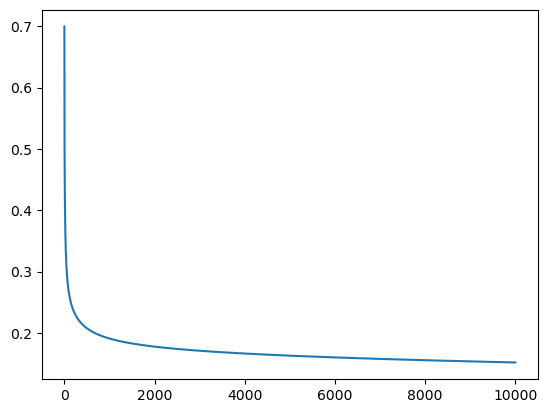

In [12]:
plt.plot(Jtr_hist)

Plot of model against training and testing data. 
This is an example of model of high variance. 

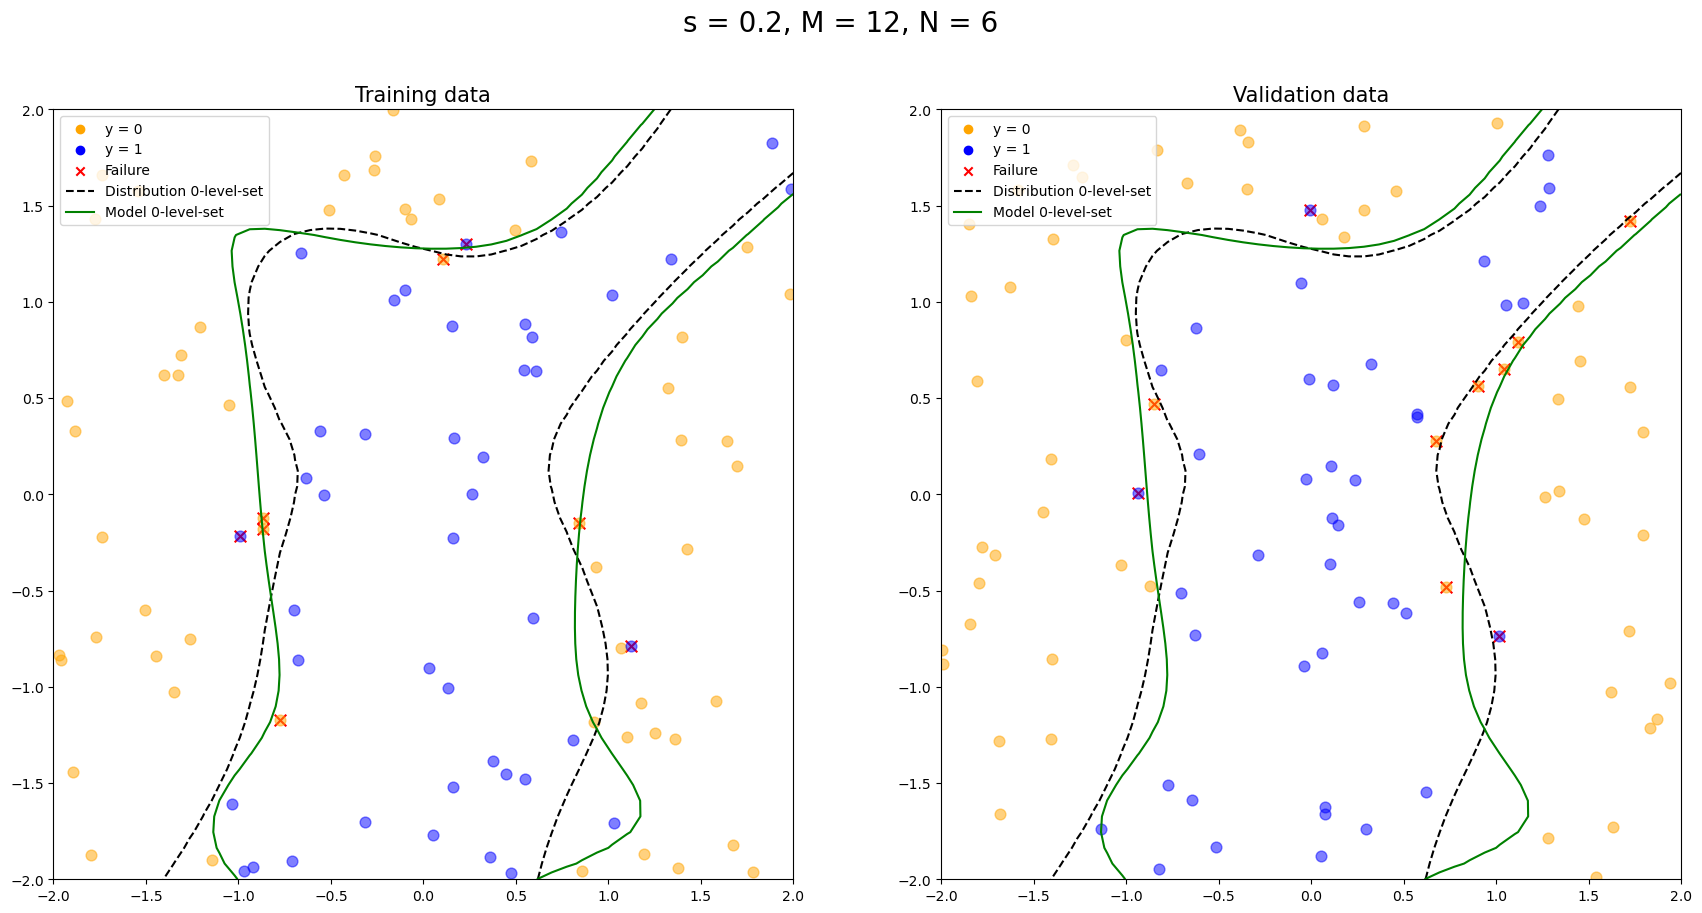

In [13]:
ps = 60 # Size of points in plot (def. 30)
alpha = 0.5

fig, ax = plt.subplots(1,2, figsize = (21,10))

## Training data
# Giving array of failures 
(X, y) = dataset.tensors
logit = model(X)
y_pred = torch.where(logit >= 0, torch.ones_like(logit),torch.zeros_like(logit)) # Predictor for given x data
pred_fail = torch.where(y_pred == y[:len(y_pred)],torch.zeros_like(logit),torch.ones_like(logit)) # Tensor of failures 1 or success 0 for each dataset 
# Separating successfully and unsuccessfully predicted 0 and 1s
x_0_succ = []
x_0_fail = [] 
x_1_succ = [] 
x_1_fail = [] 
for i in range(len(x_arr)):
    if y_arr[i][0] == 0:
        if pred_fail[i,0] == 1: x_0_fail.append(x_arr[i])
        else: x_0_succ.append(x_arr[i])
    else: 
        if pred_fail[i,0] == 1: x_1_fail.append(x_arr[i])
        else: x_1_succ.append(x_arr[i])
x_0_succ = np.array(x_0_succ); x_0_fail = np.array(x_0_fail); x_1_succ = np.array(x_1_succ); x_1_fail = np.array(x_1_fail); 
# Plotting
if len(x_0_fail) > 0:  ax[0].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
if len(x_1_fail) > 0:  ax[0].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
if len(x_0_succ) > 0:  ax[0].scatter(x_0_succ.transpose()[0],x_0_succ.transpose()[1], color = 'orange', s = ps, alpha = alpha)
if len(x_1_succ) > 0: ax[0].scatter(x_1_succ.transpose()[0],x_1_succ.transpose()[1], color = 'blue', s = ps, alpha = alpha)
if len(x_0_fail) > 0:  ax[0].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'orange', s = ps, alpha = alpha)
if len(x_1_fail) > 0: ax[0].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1], color = 'blue', s = ps, alpha = alpha)
ax[0].scatter([],[],color = 'orange', label = 'y = 0')
ax[0].scatter([],[],color = 'blue', label = 'y = 1')
ax[0].scatter([],[], color = 'red', marker = 'x', label = 'Failure')
ax[0].set_xlim((-2,2))
ax[0].set_ylim((-2,2))
# Zero level set for prob-dist function f
X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
Z = np.zeros((len(X0),len(X1)))
for i in range(50):
    for j in range(50):
        Z[i,j] = f([X0[i,j],X1[i,j]])
ax[0].contour(X0,X1,Z, levels =[0], linestyles = '--',colors = 'black')
ax[0].plot([],color = 'black',linestyle = '--',label = 'Distribution 0-level-set')
ax[0].plot([])
# Zero level set for prob-dist function f
X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
Z = np.zeros((len(X0),len(X1)))
for i in range(50):
    for j in range(50):
        x = torch.tensor([[X0[i,j],X1[i,j]]])
        z = x_to_z(x,M,mean,std).to(torch.float32)
        Z[i,j] = model(z).item()
ax[0].contour(X0,X1,Z, levels =[0], colors = 'green')
ax[0].plot([],color = 'green',label = 'Model 0-level-set')
ax[0].legend(loc = 2)
ax[0].title.set_text('Training data')
ax[0].title.set_size(15)

## Validation data
# Giving array of failures 
(X, y) = dataset_tst.tensors
logit = model(X)
y_pred = torch.where(logit >= 0, torch.ones_like(logit),torch.zeros_like(logit)) # Predictor for given x data
pred_fail = torch.where(y_pred == y[:len(y_pred)],torch.zeros_like(logit),torch.ones_like(logit)) # Tensor of failures 1 or success 0 for each dataset 
# Separating successfully and unsuccessfully predicted 0 and 1s
x_0_succ = []
x_0_fail = [] 
x_1_succ = [] 
x_1_fail = [] 
for i in range(len(x_tst_arr)):
    if y_tst_arr[i][0] == 0:
        if pred_fail[i,0] == 1: x_0_fail.append(x_tst_arr[i])
        else: x_0_succ.append(x_tst_arr[i])
    else: 
        if pred_fail[i,0] == 1: x_1_fail.append(x_tst_arr[i])
        else: x_1_succ.append(x_tst_arr[i])
x_0_succ = np.array(x_0_succ); x_0_fail = np.array(x_0_fail); x_1_succ = np.array(x_1_succ); x_1_fail = np.array(x_1_fail); 
# Plotting
if len(x_0_fail) > 0:  ax[1].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
if len(x_1_fail) > 0:  ax[1].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
if len(x_0_succ) > 0:  ax[1].scatter(x_0_succ.transpose()[0],x_0_succ.transpose()[1], color = 'orange', s = ps, alpha = alpha)
if len(x_1_succ) > 0: ax[1].scatter(x_1_succ.transpose()[0],x_1_succ.transpose()[1], color = 'blue', s = ps, alpha = alpha)
if len(x_0_fail) > 0:  ax[1].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'orange', s = ps, alpha = alpha)
if len(x_1_fail) > 0: ax[1].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1],color = 'blue', s = ps, alpha = alpha)
ax[1].scatter([],[],color = 'orange', label = 'y = 0')
ax[1].scatter([],[],color = 'blue', label = 'y = 1')
ax[1].scatter([],[], color = 'red', marker = 'x', label = 'Failure')
ax[1].set_xlim((-2,2))
ax[1].set_ylim((-2,2))
# Zero level set for prob-dist function f
X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
Z = np.zeros((len(X0),len(X1)))
for i in range(50):
    for j in range(50):
        Z[i,j] = f([X0[i,j],X1[i,j]])
ax[1].contour(X0,X1,Z, levels =[0], linestyles = '--',colors = 'black')
ax[1].plot([],color = 'black',linestyle = '--',label = 'Distribution 0-level-set')
ax[1].plot([])
# Zero level set for prob-dist function f
X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
Z = np.zeros((len(X0),len(X1)))
for i in range(50):
    for j in range(50):
        x = torch.tensor([[X0[i,j],X1[i,j]]])
        z = x_to_z(x,M,mean,std).to(torch.float32)
        Z[i,j] = model(z).item()
ax[1].contour(X0,X1,Z, levels =[0], colors = 'green')
ax[1].plot([],color = 'green',label = 'Model 0-level-set')
ax[1].legend(loc = 2)
ax[1].title.set_text('Validation data')
ax[1].title.set_size(15)

fig.suptitle(f's = {s}, M = {M}, N = {N}', fontsize = 20)

plt.show()


## Defining Class

The following example shows that random class attributes must be assigned within the init method.

In [14]:
# Example
class ex0:
    one = np.random.normal()
class ex1:
    def __init__(self):
        self.one = np.random.normal()
ex0_a = ex0(); ex0_b = ex0(); ex1_a = ex1(); ex1_b = ex1(); 
print('ex0_a.one:', ex0_a.one,'ex0_b.one:', ex0_b.one, 'ex1_a.one:', ex1_a.one,'ex1_b.one:', ex1_b.one)

ex0_a.one: 0.9868789635133126 ex0_b.one: 0.9868789635133126 ex1_a.one: -0.33436519959493954 ex1_b.one: 2.4051074611287695


In [15]:
def give_arr_data(dataset_size, N , s , f):
    '''
    Gives array of predictor variables x_arr and array of traget variables y_arr
    '''
    x_arr = np.random.uniform(low = -2, high = 2, size = (dataset_size,2)) # Predictor variables
    y_arr = []
    for x in x_arr:
        e = np.random.normal(scale = s, size = (2,))
        if f(x + e) >= 0: y_arr.append([1])
        else: y_arr.append([0])
    y_arr = np.array(y_arr) # Target variables
    return x_arr, y_arr

def x_to_xx(x_ts,M):
    '''
    Given torch tensor input in the form [x_0,x_1,x_2,...] where x_j is a (2,) tensor for each j, 
    returns [xx_0,xx_1,xx_2,...] where, for each j, xxj is a 1d tensor whose elements const of all non-constant monomials 
    of variables x_j[0] and x_j[1] with at most degree M (e.g.  for M = 2 elements are x_j[0], x_j[1], x_j[0]**2, x_j[1]**2, x_j[0]*x_j[1])
    '''
    xx_lst = []
    for n in range(len(x_ts)):
        xx = []
        x = x_ts[n]
        for i in range(M+1):
            for j in range(M+1):
                if i + j <= M and i + j > 0:
                    xx.append((x[0]**i)*(x[1]**j))
        xx_lst.append(xx)
    return torch.tensor(xx_lst)

def xx_to_z(xx_ts, mean, std):
    '''
    Rescales polynomial features xx_ts.
    mean and std should be computed as:
        mean = torch.mean(xx_train_ts, dim = 0)
        std = torch.std(xx_train_ts, dim = 0)
    '''
    
    std = torch.where(std != 0.0, std, torch.ones(std.shape)) # Avoid division by zero
    return (xx_ts - mean)/std 

def x_to_z(x_ts,M,mean,std): return xx_to_z(x_to_xx(x_ts,M),mean,std)

def give_error(dataset,model):
    '''
    Counting fraction of correct labels.
    '''
    (X, y) = dataset.tensors
    logit = model(X)
    y_pred = torch.where(logit >= 0, torch.ones_like(logit),torch.zeros_like(logit)) # Predictor for given x data
    pred_failures = torch.where(y_pred == y[:len(y_pred)],torch.zeros_like(logit),torch.ones_like(logit)) # Tensor of failures 1 or success 0 for each dataset 
    err = pred_failures.sum() # total number successes in batch
    return err/len(dataset)

class LinModel(nn.Module):
    def __init__(self,n):
        super(LinModel,self).__init__()
        self.lin = nn.Linear(n,1)
        
    def forward(self,x): 
        return self.lin(x)
    

class experiment:

    def __init__(self,N):
        self.N = N
        self.f_sd = 0.5 #  Standard deviation in coefficients of distribution
        self.f_coeff = np.random.normal(scale = 0.5, size= (N+1,N+1)) # Coefficients of distribution
    
    
    def f(self,x):
        N = self.N
        tmp = 0
        for i in range(self.N+1):
            for j in range(self.N+1):
                if i + j <= N: tmp += self.f_coeff[i,j]*(x[0]**i)*(x[1]**j)
        return tmp
    
    def plot_dist(self):
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                Z[i,j] = self.f([X0[i,j],X1[i,j]])
        plt.figure(figsize=(5, 5))
        plt.contour(X0,X1,Z, levels =[0], linestyles = '--')
        plt.xlim((-2,2))
        plt.ylim((-2,2))
        plt.title('Zero level set of $f$')
        plt.show()
    
    # N = 6
    s = 0.2 # Dataset noise (in target variable)
    dataset_size = 100
    validset_size = 100

    # Learning parameters
    learning_rate = 0.1
    n_epochs = 10000
    batch_size = 20
    weight_decay = 0

    # Capacity of model (polynomial degree)
    M = 12

    # Rate of printing
    n_print = 500 # Print after every `n_print` epochs
    
    model = None
    # History lists (recording every epoch)
    Jtr_hist = None # Training cost history 
    Jtst_hist = None # Testing cost history 
    
    mean = None
    std = None
    
        
    def go(self):
        N = self.N
        f = self.f
        s = self.s
        dataset_size = self.dataset_size
        validset_size = self.validset_size
        learning_rate = self.learning_rate
        n_epochs = self.n_epochs
        batch_size = self.batch_size
        M = self.M
        n_print = self.n_print
        weight_decay = self.weight_decay

        # Creating training dataset
        x_arr, y_arr = give_arr_data(dataset_size, N , s , f)
        x_ts = torch.from_numpy(x_arr); y_ts = torch.from_numpy(y_arr)
        xx_ts = x_to_xx(x_ts,M); 

        mean = torch.mean(xx_ts, dim = 0) # For rescaling
        std = torch.std(xx_ts, dim = 0)
        z_ts = xx_to_z(xx_ts, mean,std)

        z_ts = z_ts.type(torch.float32); y_ts = y_ts.type(torch.float32); # converting to single precision float
        dataset = TensorDataset(z_ts,y_ts)


        # Creating testing dataset
        x_tst_arr, y_tst_arr = give_arr_data(validset_size, N , s , f)
        x_tst_ts = torch.from_numpy(x_tst_arr); y_tst_ts = torch.from_numpy(y_tst_arr)
        xx_tst_ts = x_to_xx(x_tst_ts,M)
        z_tst_ts = xx_to_z(xx_tst_ts, mean,std)

        z_tst_ts = z_tst_ts.type(torch.float32); y_tst_ts = y_tst_ts.type(torch.float32); # converting to single precision float
        dataset_tst = TensorDataset(z_tst_ts,y_tst_ts)

        Jtr_hist = []
        Jtst_hist = []
        
        # Specify traing and testing dataloaders. (By convention testing data has batch size = 1).
        data_train = DataLoader(dataset, batch_size = batch_size)
        data_tst = DataLoader(dataset_tst)

        # Initiating model
        model = LinModel(z_ts.shape[1])
        loss_fn = nn.BCEWithLogitsLoss() # https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
        
        tr_err = None
        tst_err = None
        

        for t in range(n_epochs):
            Jtr_epoch = 0.0 # Training cost for epoch
            for batch, (X,y) in enumerate(data_train):
                # Compute prediction and loss
                pred = model(X)
                loss = loss_fn(pred, y)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Recording loss
                Jtr_epoch += loss.item()

            Jtr_epoch = Jtr_epoch/len(data_train)
            Jtr_hist.append(Jtr_epoch)
            Jtst_epoch = give_error(dataset_tst, model)
            Jtst_hist.append(Jtst_epoch)

            # Printing every `n_print` epochs
            if t % n_print == 0:
                print(f"Epoch {t}. Training cost: {Jtr_epoch:>6f}. Testing error: {Jtst_epoch:>6f}")

        tr_err = give_error(dataset, model); tst_err = give_error(dataset_tst, model)
        print(f"End. Training error: {tr_err:>6f}. Testing error: {tst_err:>6f}")
        
        self.x_arr = x_arr; self.y_arr = y_arr; self.x_tst_arr = x_tst_arr; self.y_tst_arr = y_tst_arr;
        self.dataset = dataset; self.dataset_tst = dataset_tst;
        self.model = model
        self.Jtst_hist = Jtst_hist; self.Jtr_hist = Jtr_hist 
        self.mean = mean; self.std = std;
        self.tr_err = tr_err; self.tst_err = tst_err
        
        
    
    ps = 60 # Size of points in plot (def. 30)
    alpha = 0.5
    loc = 2
        
    def plot_model(self):
        x_arr = self.x_arr; y_arr = self.y_arr; x_tst_arr = self.x_tst_arr; y_tst_arr = self.y_tst_arr;
        dataset = self.dataset; dataset_tst = self.dataset_tst;
        model = self.model; f = self.f
        s = self.s; N = self.N; M = self.M; mean = self.mean; std = self.std
        
        ps = self.ps
        alpha = self.alpha

        fig, ax = plt.subplots(1,2, figsize = (21,10))

        ## Training data
        # Giving array of failures 
        (X, y) = dataset.tensors
        logit = model(X)
        y_pred = torch.where(logit >= 0, torch.ones_like(logit),torch.zeros_like(logit)) # Predictor for given x data
        pred_fail = torch.where(y_pred == y[:len(y_pred)],torch.zeros_like(logit),torch.ones_like(logit)) # Tensor of failures 1 or success 0 for each dataset 
        # Separating successfully and unsuccessfully predicted 0 and 1s
        x_0_succ = []
        x_0_fail = [] 
        x_1_succ = [] 
        x_1_fail = [] 
        for i in range(len(x_arr)):
            if y_arr[i][0] == 0:
                if pred_fail[i,0] == 1: x_0_fail.append(x_arr[i])
                else: x_0_succ.append(x_arr[i])
            else: 
                if pred_fail[i,0] == 1: x_1_fail.append(x_arr[i])
                else: x_1_succ.append(x_arr[i])
        x_0_succ = np.array(x_0_succ); x_0_fail = np.array(x_0_fail); x_1_succ = np.array(x_1_succ); x_1_fail = np.array(x_1_fail); 
        # Plotting
        if len(x_0_fail) > 0:  ax[0].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
        if len(x_1_fail) > 0:  ax[0].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
        if len(x_0_succ) > 0:  ax[0].scatter(x_0_succ.transpose()[0],x_0_succ.transpose()[1], color = 'orange', s = ps, alpha = alpha)
        if len(x_1_succ) > 0: ax[0].scatter(x_1_succ.transpose()[0],x_1_succ.transpose()[1], color = 'blue', s = ps, alpha = alpha)
        if len(x_0_fail) > 0:  ax[0].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'orange', s = ps, alpha = alpha)
        if len(x_1_fail) > 0: ax[0].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1], color = 'blue', s = ps, alpha = alpha)
        ax[0].scatter([],[],color = 'orange', label = 'y = 0')
        ax[0].scatter([],[],color = 'blue', label = 'y = 1')
        ax[0].scatter([],[], color = 'red', marker = 'x', label = 'Failure')
        ax[0].set_xlim((-2,2))
        ax[0].set_ylim((-2,2))
        # Zero level set for prob-dist function f
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                Z[i,j] = f([X0[i,j],X1[i,j]])
        ax[0].contour(X0,X1,Z, levels =[0], linestyles = '--',colors = 'black')
        ax[0].plot([],color = 'black',linestyle = '--',label = 'Distribution 0-level-set')
        ax[0].plot([])
        # Zero level set for prob-dist function f
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                x = torch.tensor([[X0[i,j],X1[i,j]]])
                z = x_to_z(x,M,mean,std).to(torch.float32)
                Z[i,j] = model(z).item()
        ax[0].contour(X0,X1,Z, levels =[0], colors = 'green')
        ax[0].plot([],color = 'green',label = 'Model 0-level-set')
        ax[0].legend(loc = self.loc)
        ax[0].title.set_text('Training data')
        ax[0].title.set_size(15)

        ## Validation data
        # Giving array of failures 
        (X, y) = dataset_tst.tensors
        logit = model(X)
        y_pred = torch.where(logit >= 0, torch.ones_like(logit),torch.zeros_like(logit)) # Predictor for given x data
        pred_fail = torch.where(y_pred == y[:len(y_pred)],torch.zeros_like(logit),torch.ones_like(logit)) # Tensor of failures 1 or success 0 for each dataset 
        # Separating successfully and unsuccessfully predicted 0 and 1s
        x_0_succ = []
        x_0_fail = [] 
        x_1_succ = [] 
        x_1_fail = [] 
        for i in range(len(x_tst_arr)):
            if y_tst_arr[i][0] == 0:
                if pred_fail[i,0] == 1: x_0_fail.append(x_tst_arr[i])
                else: x_0_succ.append(x_tst_arr[i])
            else: 
                if pred_fail[i,0] == 1: x_1_fail.append(x_tst_arr[i])
                else: x_1_succ.append(x_tst_arr[i])
        x_0_succ = np.array(x_0_succ); x_0_fail = np.array(x_0_fail); x_1_succ = np.array(x_1_succ); x_1_fail = np.array(x_1_fail); 
        # Plotting
        if len(x_0_fail) > 0:  ax[1].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
        if len(x_1_fail) > 0:  ax[1].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
        if len(x_0_succ) > 0:  ax[1].scatter(x_0_succ.transpose()[0],x_0_succ.transpose()[1], color = 'orange', s = ps, alpha = alpha)
        if len(x_1_succ) > 0: ax[1].scatter(x_1_succ.transpose()[0],x_1_succ.transpose()[1], color = 'blue', s = ps, alpha = alpha)
        if len(x_0_fail) > 0:  ax[1].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'orange', s = ps, alpha = alpha)
        if len(x_1_fail) > 0: ax[1].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1],color = 'blue', s = ps, alpha = alpha)
        ax[1].scatter([],[],color = 'orange', label = 'y = 0')
        ax[1].scatter([],[],color = 'blue', label = 'y = 1')
        ax[1].scatter([],[], color = 'red', marker = 'x', label = 'Failure')
        ax[1].set_xlim((-2,2))
        ax[1].set_ylim((-2,2))
        # Zero level set for prob-dist function f
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                Z[i,j] = f([X0[i,j],X1[i,j]])
        ax[1].contour(X0,X1,Z, levels =[0], linestyles = '--',colors = 'black')
        ax[1].plot([],color = 'black',linestyle = '--',label = 'Distribution 0-level-set')
        ax[1].plot([])
        # Zero level set for prob-dist function f
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                x = torch.tensor([[X0[i,j],X1[i,j]]])
                z = x_to_z(x,M,mean,std).to(torch.float32)
                Z[i,j] = model(z).item()
        ax[1].contour(X0,X1,Z, levels =[0], colors = 'green')
        ax[1].plot([],color = 'green',label = 'Model 0-level-set')
        ax[1].legend(loc = self.loc)
        ax[1].title.set_text('Validation data')
        ax[1].title.set_size(15)

        fig.suptitle(f's = {s}, M = {M}, N = {N}', fontsize = 20)

        plt.show()
        

## High bias vs. high variance

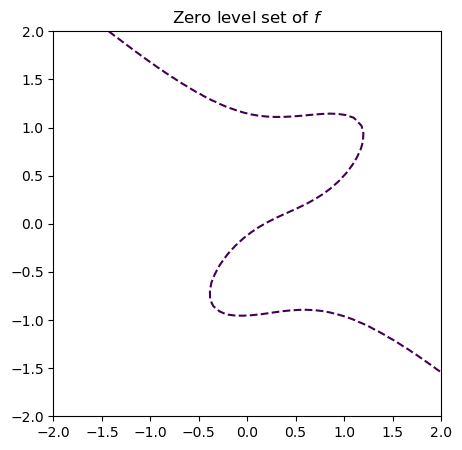

In [16]:
exp = experiment(N = 3)
exp.plot_dist()

### High variance

In [17]:
exp.M = 12 # Capacity of model (polynomial degree)
exp.s = 0.2 # Dataset noise (in target variable)
exp.dataset_size = 100
exp.validset_size = 100
# Learning parameters
exp.learning_rate = 0.1
exp.n_epochs = 10000
exp.batch_size = 20
exp.n_print = 2000 # Print after every `n_print` epochs
exp.go()

Epoch 0. Training cost: 0.648533. Testing error: 0.280000
Epoch 2000. Training cost: 0.151567. Testing error: 0.050000
Epoch 4000. Training cost: 0.135424. Testing error: 0.060000
Epoch 6000. Training cost: 0.128547. Testing error: 0.070000
Epoch 8000. Training cost: 0.124364. Testing error: 0.070000
End. Training error: 0.070000. Testing error: 0.070000


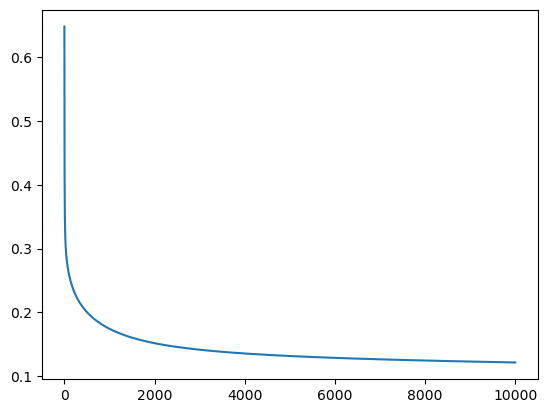

In [18]:
plt.plot(exp.Jtr_hist)

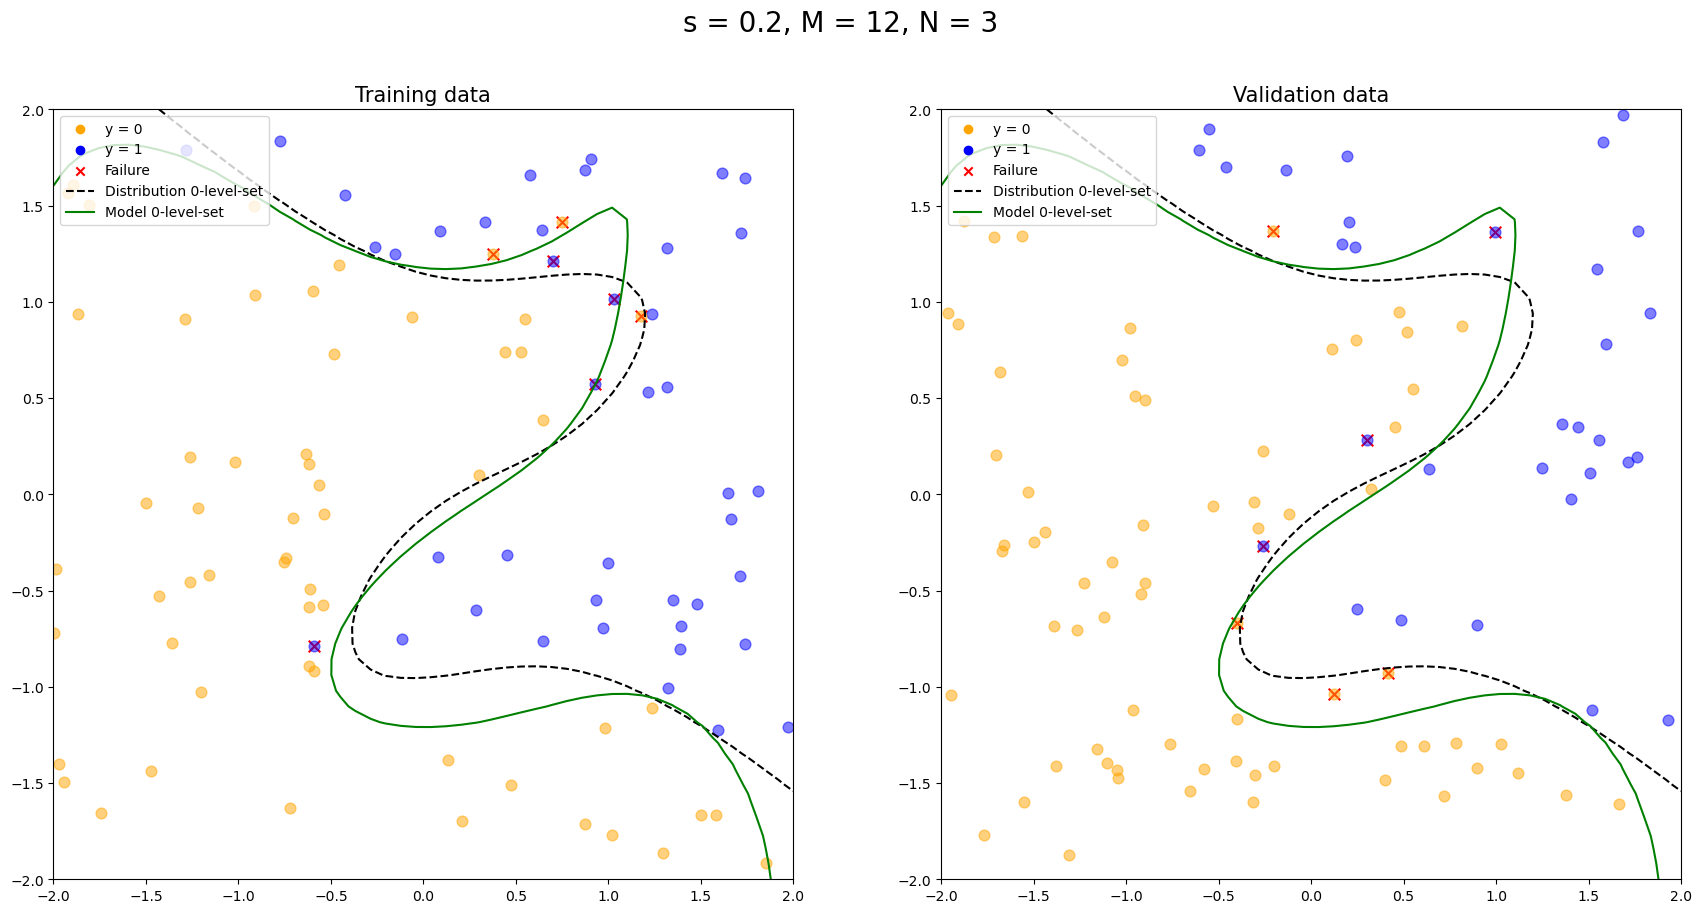

In [19]:
exp.plot_model()

### High bias

In [20]:
exp.M = 2 # Capacity of model (polynomial degree)
exp.s = 0.2 # Dataset noise (in target variable)
exp.dataset_size = 100
exp.validset_size = 100
# Learning parameters
exp.learning_rate = 0.1
exp.n_epochs = 400
exp.batch_size = 20
exp.n_print = 2000 # Print after every `n_print` epochs
exp.go()

Epoch 0. Training cost: 0.792552. Testing error: 0.550000
End. Training error: 0.140000. Testing error: 0.210000


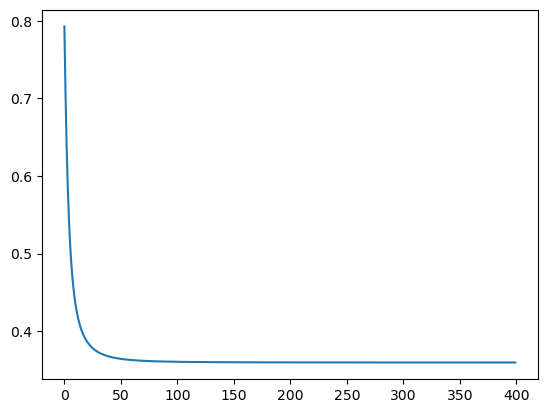

In [21]:
plt.plot(exp.Jtr_hist)

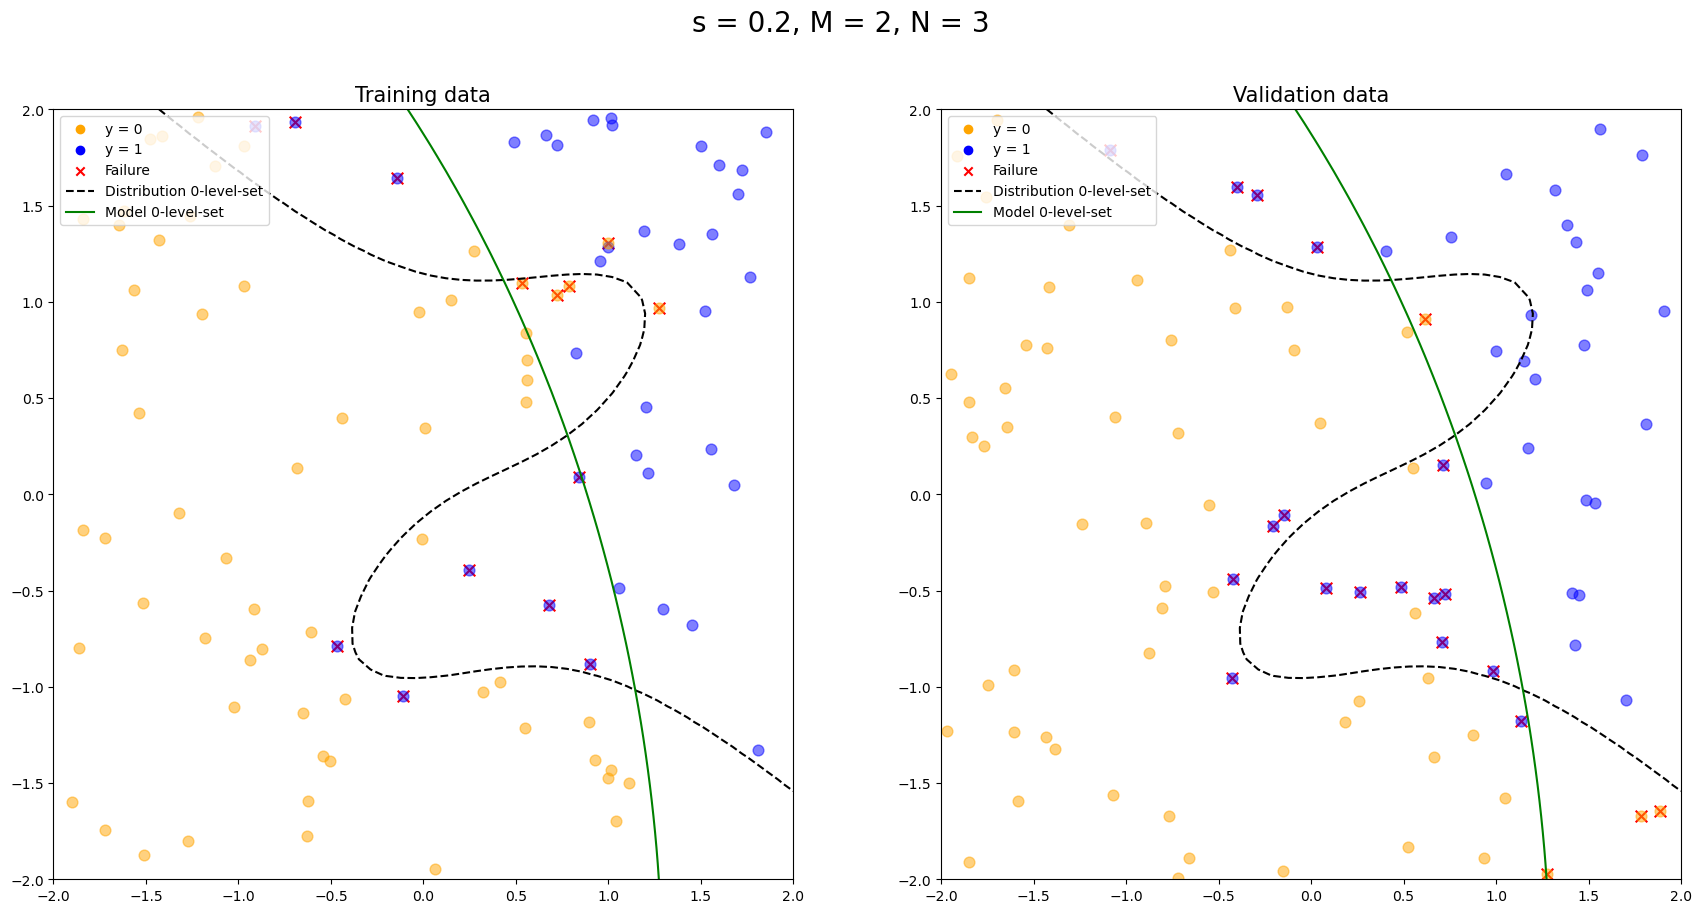

In [22]:
exp.plot_model()

### "Just right" (model degree = distribution degree)

In [23]:
exp.M = 3 # Capacity of model (polynomial degree)
exp.s = 0.2 # Dataset noise (in target variable)
exp.dataset_size = 100
exp.validset_size = 100
# Learning parameters
exp.learning_rate = 0.1
exp.n_epochs = 4000
exp.batch_size = 20
exp.n_print = 2000 # Print after every `n_print` epochs
exp.go()

Epoch 0. Training cost: 0.708178. Testing error: 0.470000
Epoch 2000. Training cost: 0.265812. Testing error: 0.110000
End. Training error: 0.130000. Testing error: 0.110000


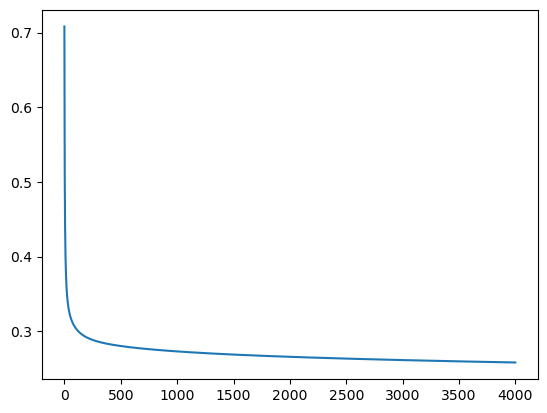

In [24]:
plt.plot(exp.Jtr_hist)

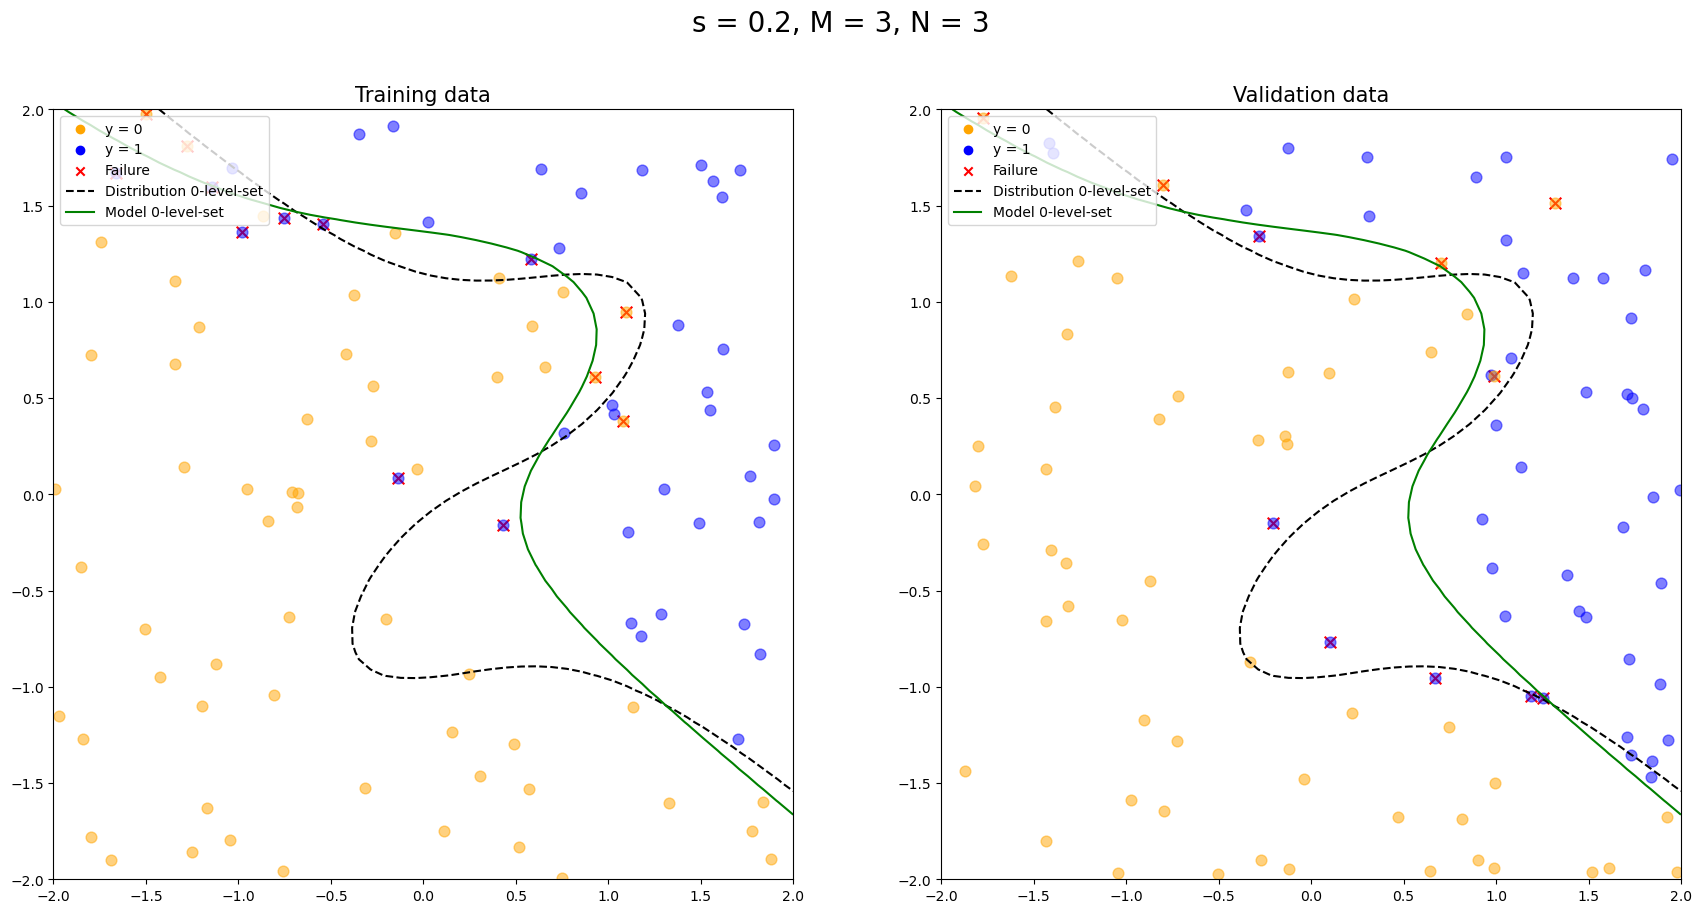

In [25]:
exp.plot_model()

## Capacity (polynomial degree) vs. training and testing error 

In [26]:
N = 4
M_vals = range(1,13)

In [27]:
exp  = experiment(N)

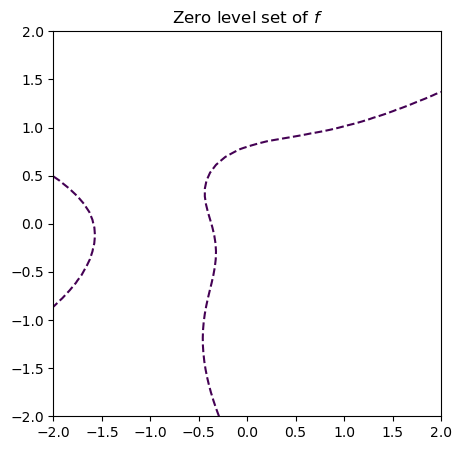

In [28]:
exp.plot_dist()

In [29]:
exp.dataset_size = 100
exp.validset_size = 100
# Learning parameters
exp.learning_rate = 0.1
exp.n_epochs = 10000 # Large enough so that SGD converges for all M 
exp.batch_size = 20
exp.n_print = 20000 # Print after every `n_print` epochs

### No noise (s = 0)

In [30]:
tr_err_no_noise = []
tst_err_no_noise = []
exp.s = 0 # Dataset noise (in target variable)
for M in M_vals:
    exp.M = M
    exp.go()
    tr_err_no_noise.append(exp.tr_err)
    tst_err_no_noise.append(exp.tst_err)

Epoch 0. Training cost: 0.634770. Testing error: 0.320000
End. Training error: 0.200000. Testing error: 0.150000
Epoch 0. Training cost: 0.744907. Testing error: 0.520000
End. Training error: 0.000000. Testing error: 0.090000
Epoch 0. Training cost: 0.774474. Testing error: 0.490000
End. Training error: 0.020000. Testing error: 0.030000
Epoch 0. Training cost: 0.618344. Testing error: 0.350000
End. Training error: 0.000000. Testing error: 0.050000
Epoch 0. Training cost: 0.579529. Testing error: 0.100000
End. Training error: 0.000000. Testing error: 0.040000
Epoch 0. Training cost: 0.631098. Testing error: 0.200000
End. Training error: 0.000000. Testing error: 0.010000
Epoch 0. Training cost: 0.715005. Testing error: 0.340000
End. Training error: 0.000000. Testing error: 0.070000
Epoch 0. Training cost: 0.561355. Testing error: 0.080000
End. Training error: 0.000000. Testing error: 0.050000
Epoch 0. Training cost: 0.597388. Testing error: 0.170000
End. Training error: 0.000000. Testing

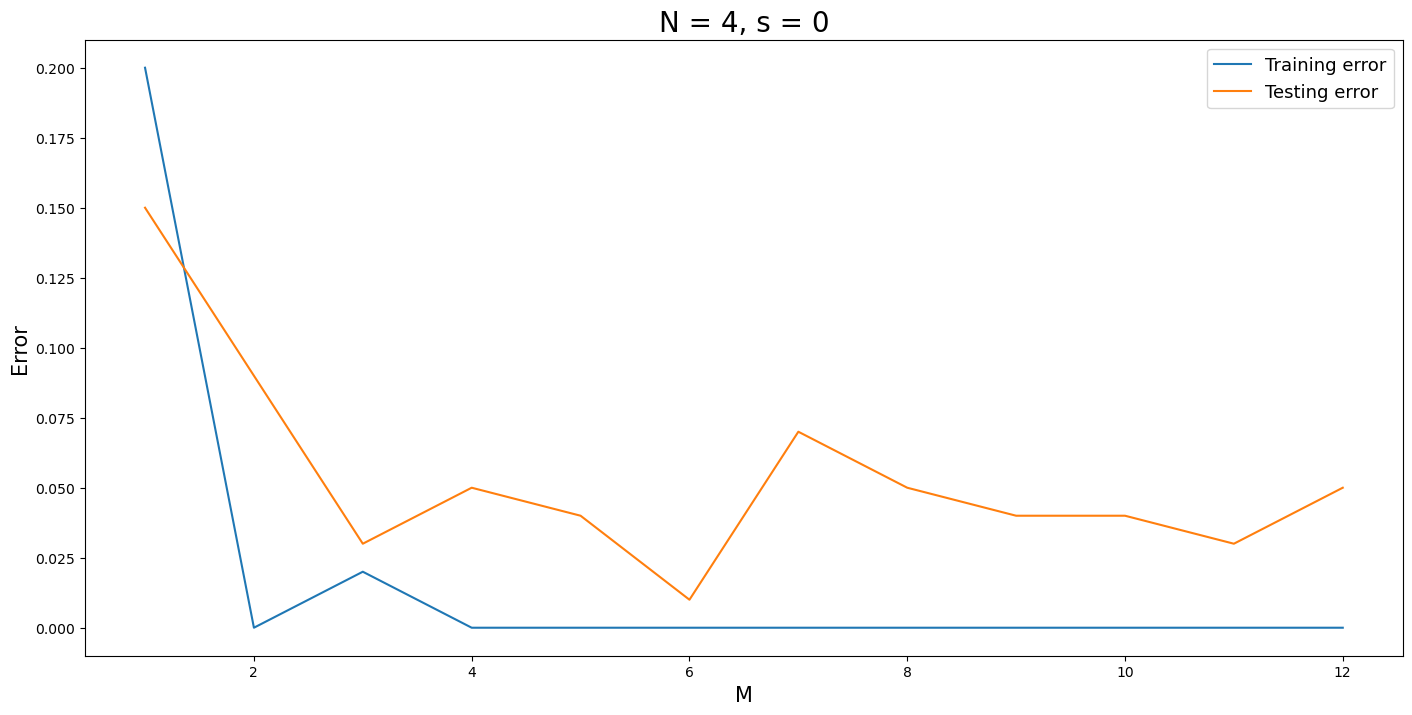

In [31]:
plt.figure(figsize = (17,8))
plt.plot(M_vals, tr_err_no_noise, label = 'Training error')
plt.plot(M_vals, tst_err_no_noise, label = 'Testing error')
plt.xlabel('M', size = 15)
plt.ylabel('Error', size = 15)
plt.title(f'N = {exp.N}, s = {exp.s}', size = 20)
plt.legend(prop={'size': 13})
plt.show()

### Medium noise (s = 0.15)

In [32]:
tr_err_med_noise = []
tst_err_med_noise = []
exp.s = 0.1 # Dataset noise (in target variable)
for M in M_vals:
    exp.M = M
    exp.go()
    tr_err_med_noise.append(exp.tr_err)
    tst_err_med_noise.append(exp.tst_err)

Epoch 0. Training cost: 0.969666. Testing error: 0.590000
End. Training error: 0.110000. Testing error: 0.110000
Epoch 0. Training cost: 0.663507. Testing error: 0.290000
End. Training error: 0.030000. Testing error: 0.070000
Epoch 0. Training cost: 0.674978. Testing error: 0.290000
End. Training error: 0.030000. Testing error: 0.050000
Epoch 0. Training cost: 0.600158. Testing error: 0.240000
End. Training error: 0.020000. Testing error: 0.040000
Epoch 0. Training cost: 0.733915. Testing error: 0.240000
End. Training error: 0.030000. Testing error: 0.070000
Epoch 0. Training cost: 0.671323. Testing error: 0.150000
End. Training error: 0.000000. Testing error: 0.080000
Epoch 0. Training cost: 0.625475. Testing error: 0.200000
End. Training error: 0.020000. Testing error: 0.070000
Epoch 0. Training cost: 0.626406. Testing error: 0.180000
End. Training error: 0.020000. Testing error: 0.050000
Epoch 0. Training cost: 0.548382. Testing error: 0.150000
End. Training error: 0.000000. Testing

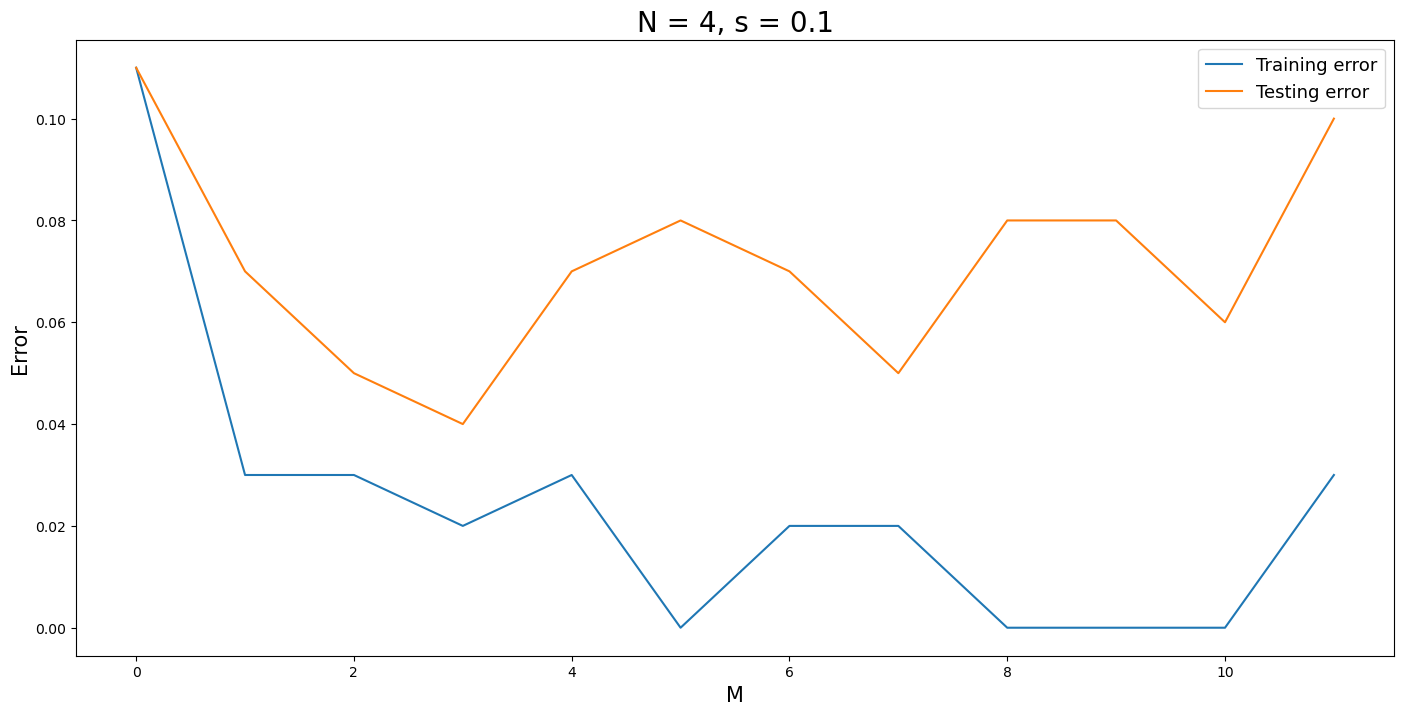

In [33]:
plt.figure(figsize = (17,8))
plt.plot(tr_err_med_noise, label = 'Training error')
plt.plot(tst_err_med_noise, label = 'Testing error')
plt.xlabel('M', size = 15)
plt.ylabel('Error', size = 15)
plt.title(f'N = {exp.N}, s = {exp.s}', size = 20)
plt.legend(prop={'size': 13})
plt.show()

### Strong noise (s = 0.3)

In [34]:
tr_err_str_noise = []
tst_err_str_noise = []
exp.s = 0.2 # Dataset noise (in target variable)
for M in M_vals:
    exp.M = M
    exp.go()
    tr_err_str_noise.append(exp.tr_err)
    tst_err_str_noise.append(exp.tst_err)

Epoch 0. Training cost: 0.857262. Testing error: 0.630000
End. Training error: 0.240000. Testing error: 0.250000
Epoch 0. Training cost: 0.758822. Testing error: 0.570000
End. Training error: 0.080000. Testing error: 0.100000
Epoch 0. Training cost: 0.687453. Testing error: 0.230000
End. Training error: 0.060000. Testing error: 0.060000
Epoch 0. Training cost: 0.769112. Testing error: 0.410000
End. Training error: 0.050000. Testing error: 0.080000
Epoch 0. Training cost: 0.705093. Testing error: 0.350000
End. Training error: 0.050000. Testing error: 0.070000
Epoch 0. Training cost: 0.678836. Testing error: 0.300000
End. Training error: 0.000000. Testing error: 0.040000
Epoch 0. Training cost: 0.636220. Testing error: 0.250000
End. Training error: 0.010000. Testing error: 0.080000
Epoch 0. Training cost: 0.561116. Testing error: 0.240000
End. Training error: 0.020000. Testing error: 0.110000
Epoch 0. Training cost: 0.586426. Testing error: 0.150000
End. Training error: 0.020000. Testing

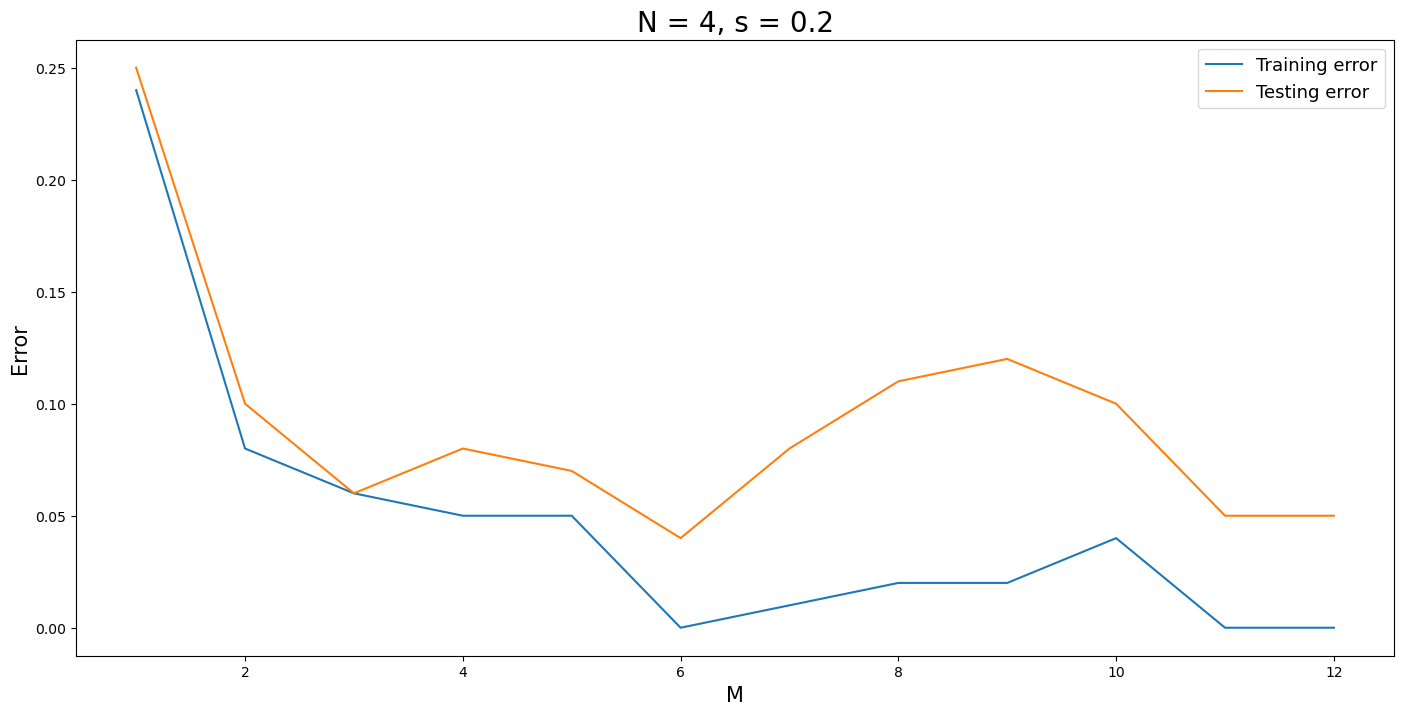

In [35]:
plt.figure(figsize = (17,8))
plt.plot(M_vals, tr_err_str_noise, label = 'Training error')
plt.plot(M_vals, tst_err_str_noise, label = 'Testing error')
plt.xlabel('M', size = 15)
plt.ylabel('Error', size = 15)
plt.title(f'N = {exp.N}, s = {exp.s}', size = 20)
plt.legend(prop={'size': 13})
plt.show()

## Adding regularisation to the polynomial model

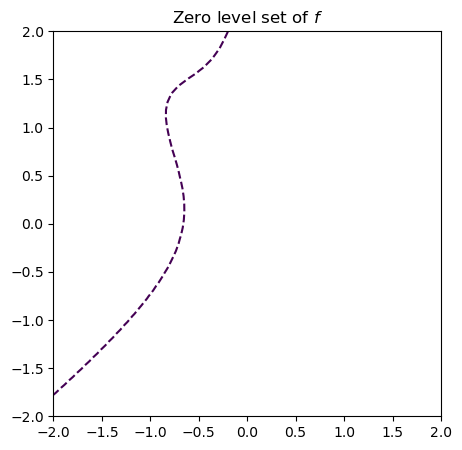

In [36]:
exp = experiment(N = 4)
exp.plot_dist()

### Without regularistion

In [37]:
exp.M = 14 # Capacity of model (polynomial degree)
exp.s = 0.2 # Dataset noise (in target variable)
exp.dataset_size = 100
exp.validset_size = 100
# Learning parameters
exp.learning_rate = 0.1
exp.n_epochs = 15000
exp.batch_size = 20
exp.n_print = 2000 # Print after every `n_print` epochs
exp.go()

Epoch 0. Training cost: 0.591367. Testing error: 0.100000
Epoch 2000. Training cost: 0.082385. Testing error: 0.080000
Epoch 4000. Training cost: 0.075462. Testing error: 0.070000
Epoch 6000. Training cost: 0.070437. Testing error: 0.080000
Epoch 8000. Training cost: 0.066423. Testing error: 0.080000
Epoch 10000. Training cost: 0.063082. Testing error: 0.080000
Epoch 12000. Training cost: 0.060230. Testing error: 0.080000
Epoch 14000. Training cost: 0.057750. Testing error: 0.080000
End. Training error: 0.030000. Testing error: 0.080000


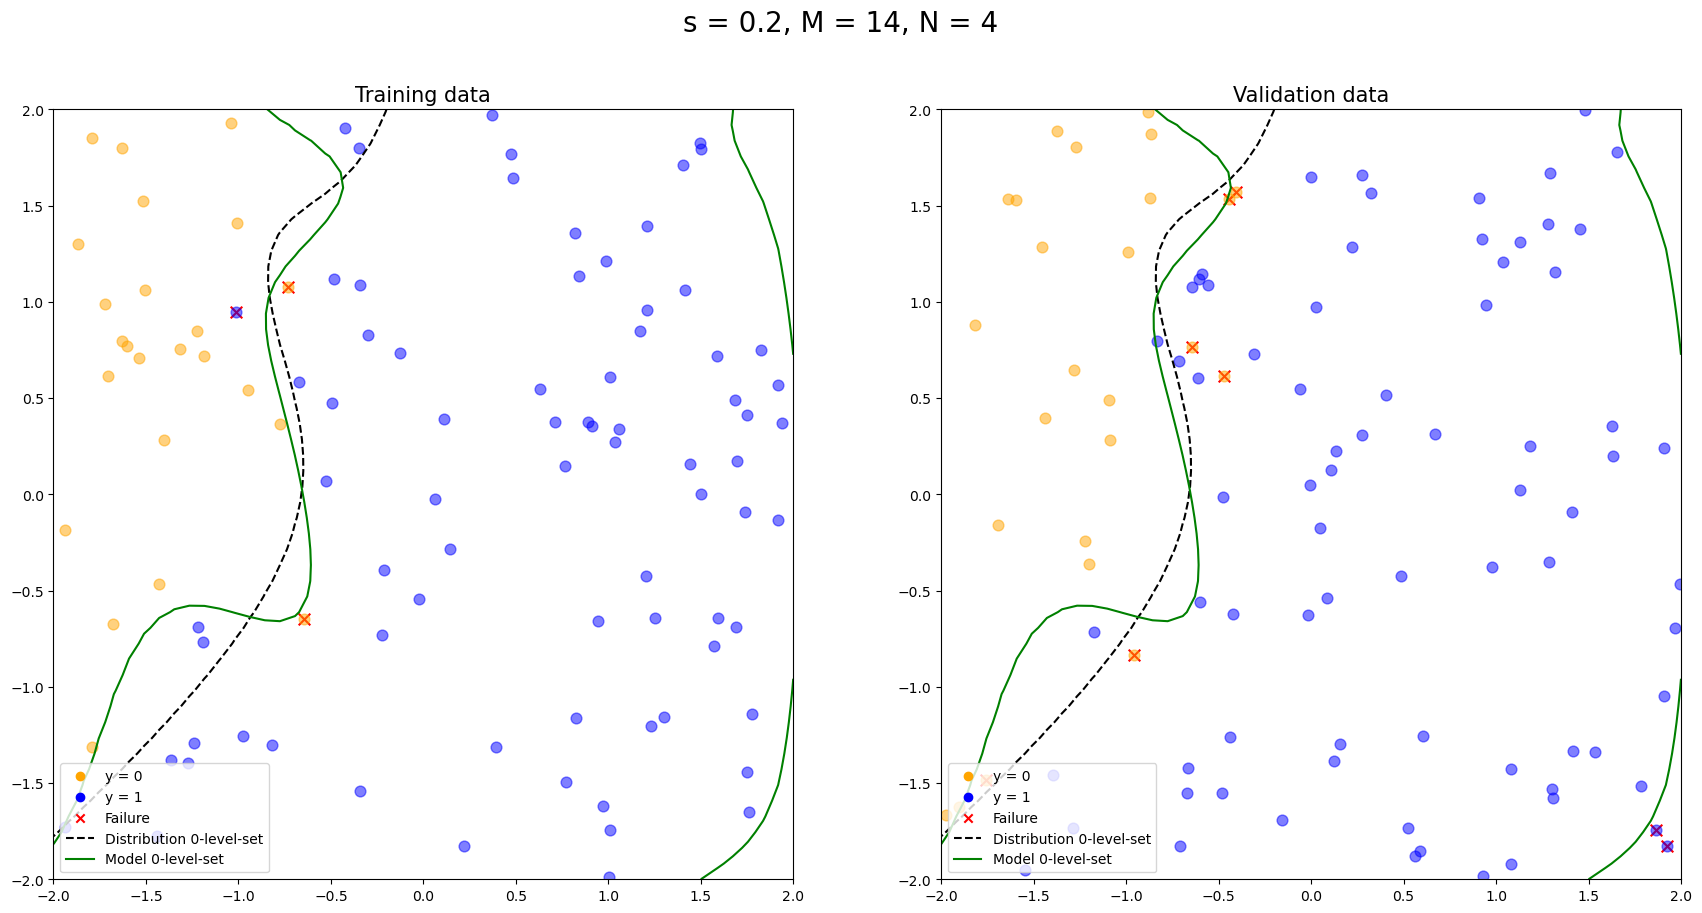

In [38]:
exp.loc = 3
exp.plot_model()

### With regularisation ($\lambda = 0.1$)

In [39]:
exp.weight_decay = 0.1
exp.go()

Epoch 0. Training cost: 0.570859. Testing error: 0.070000
Epoch 2000. Training cost: 0.216691. Testing error: 0.020000
Epoch 4000. Training cost: 0.216691. Testing error: 0.020000
Epoch 6000. Training cost: 0.216691. Testing error: 0.020000
Epoch 8000. Training cost: 0.216691. Testing error: 0.020000
Epoch 10000. Training cost: 0.216691. Testing error: 0.020000
Epoch 12000. Training cost: 0.216691. Testing error: 0.020000
Epoch 14000. Training cost: 0.216691. Testing error: 0.020000
End. Training error: 0.070000. Testing error: 0.020000


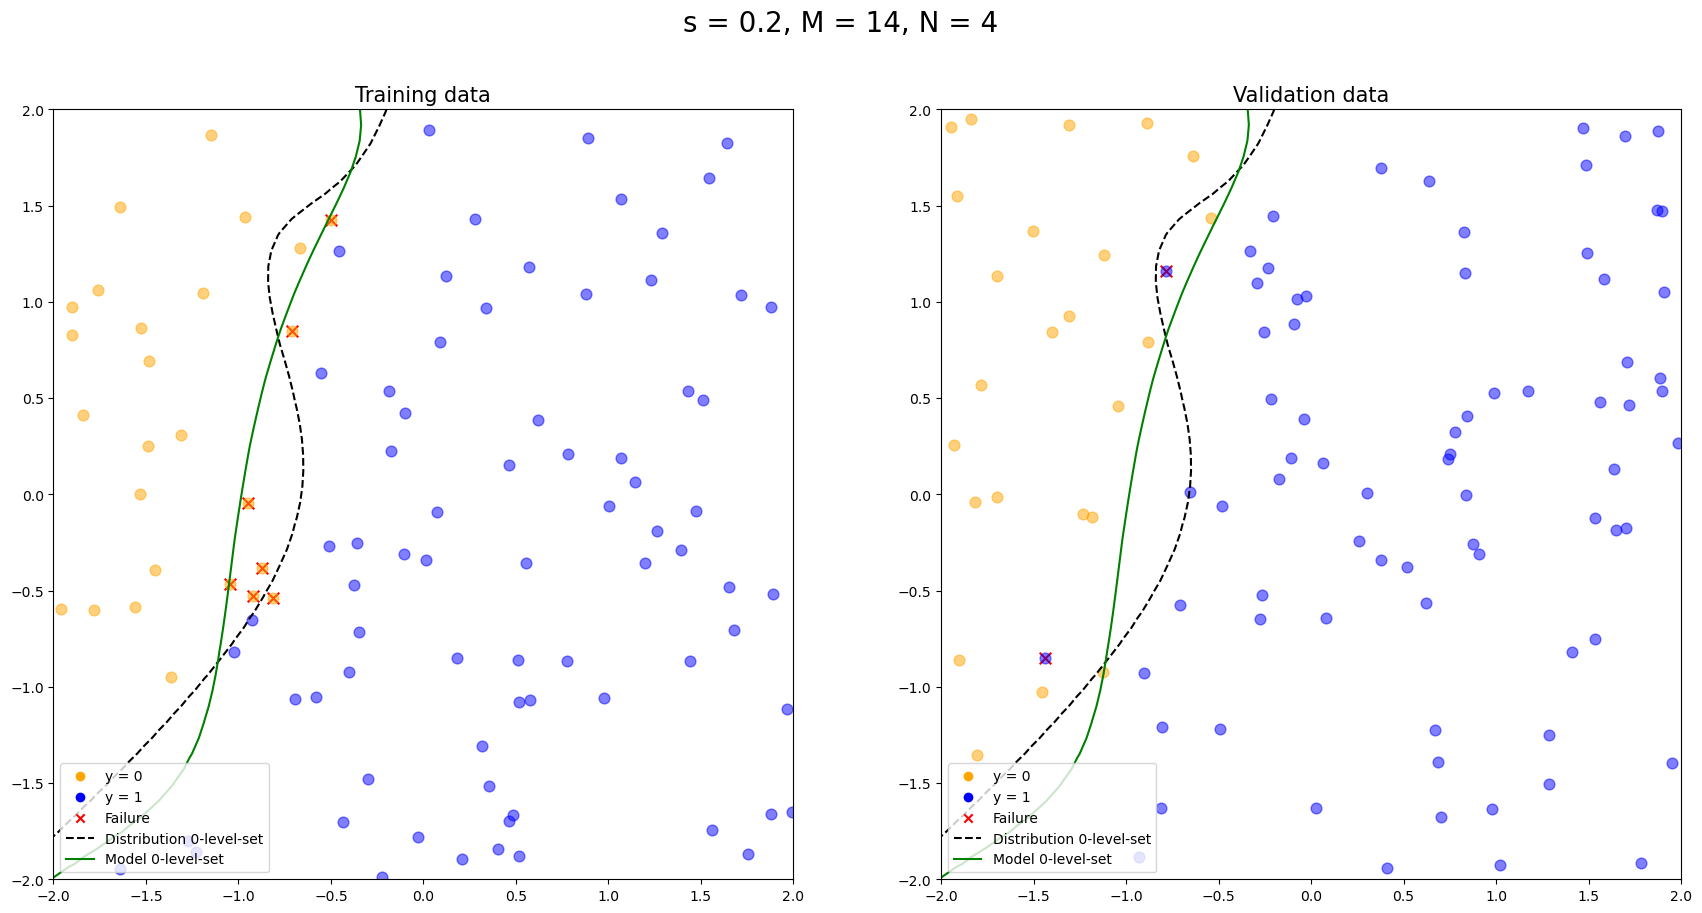

In [40]:
exp.plot_model()

### With regularisation ($\lambda = 1$)

In [41]:
exp.weight_decay = 1
exp.go()

Epoch 0. Training cost: 0.565665. Testing error: 0.140000
Epoch 2000. Training cost: 0.409698. Testing error: 0.120000
Epoch 4000. Training cost: 0.409698. Testing error: 0.120000
Epoch 6000. Training cost: 0.409698. Testing error: 0.120000
Epoch 8000. Training cost: 0.409698. Testing error: 0.120000
Epoch 10000. Training cost: 0.409698. Testing error: 0.120000
Epoch 12000. Training cost: 0.409698. Testing error: 0.120000
Epoch 14000. Training cost: 0.409698. Testing error: 0.120000
End. Training error: 0.060000. Testing error: 0.120000


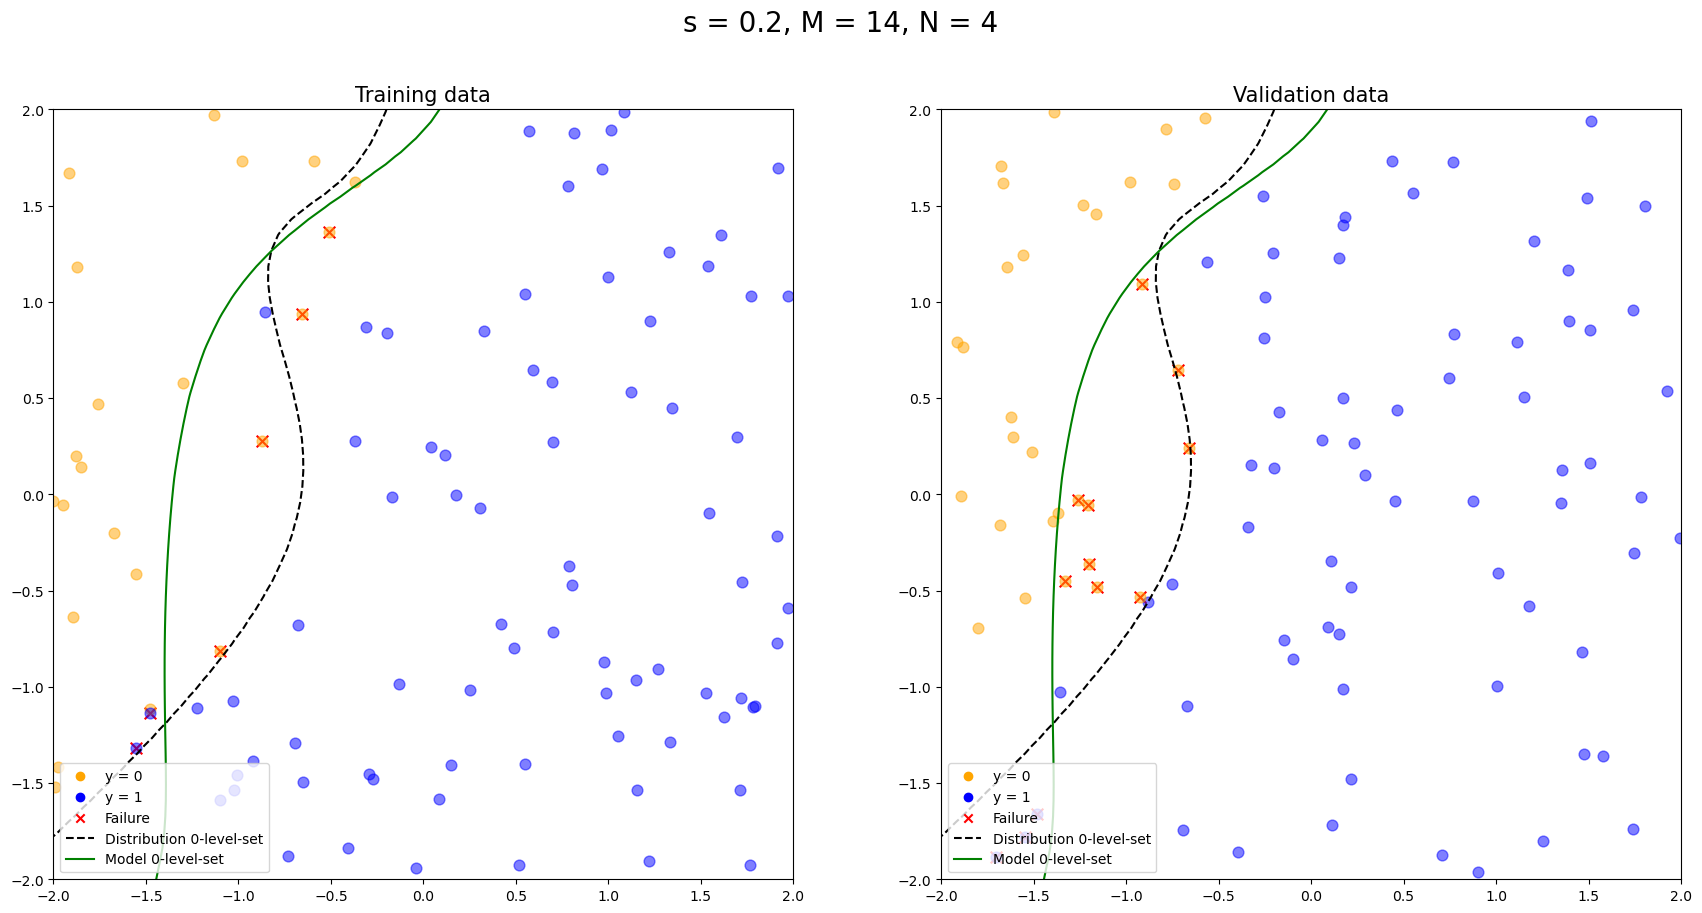

In [42]:
exp.plot_model()

## Neural network model

Next we train the above classification problem with a neural network (try one, two and three hidden layers).
In this case, we do not add polynomial features hence do not need to recale.

In [43]:
class NN_one(nn.Module):
    def __init__(self,neuron_lst):
        super(NN_one,self).__init__()
        self.stack = nn.Sequential(
        nn.Linear(2, neuron_lst[0]),
        nn.ReLU(),
        nn.Linear(neuron_lst[0],1),
    )       
    def forward(self,x): 
        return self.stack(x)

class NN_two(nn.Module):
    def __init__(self,neuron_lst):
        super(NN_two,self).__init__()
        self.stack = nn.Sequential(
        nn.Linear(2, neuron_lst[0]),
        nn.ReLU(),
        nn.Linear(neuron_lst[0],neuron_lst[1]),
        nn.ReLU(),
        nn.Linear(neuron_lst[1], 1),
    )   
    def forward(self,x): 
        return self.stack(x)
    
class NN_three(nn.Module):
    def __init__(self,neuron_lst):
        super(NN_three,self).__init__()
        self.stack = nn.Sequential(
        nn.Linear(2, neuron_lst[0]),
        nn.ReLU(),
        nn.Linear(neuron_lst[0],neuron_lst[1]),
        nn.ReLU(),
        nn.Linear(neuron_lst[1],neuron_lst[2] ),
        nn.ReLU(),
        nn.Linear(neuron_lst[2], 1),
    )     
    def forward(self,x): 
        return self.stack(x)
    

def give_error_nn(dataset,model):
    '''
    Counting fraction of correct labels. 
    '''
    (X, y) = dataset.tensors
    logit = model(X)
    y_pred = torch.where(logit >= 0, torch.ones_like(logit),torch.zeros_like(logit)) # Predictor for given x data
    pred_failures = torch.where(y_pred == y[:len(y_pred)],torch.zeros_like(logit),torch.ones_like(logit)) # Tensor of failures 1 or success 0 for each dataset 
    err = pred_failures.sum() # total number successes in batch
    return err/len(dataset)



In [44]:
class experiment_nn:
    
    def __init__(self,N):
        self.N = N
        self.f_sd = 0.5 #  Standard deviation in coefficients of distribution
        self.f_coeff = np.random.normal(scale = 0.5, size= (N+1,N+1)) # Coefficients of distribution
    
    
    def f(self,x):
        N = self.N
        tmp = 0
        for i in range(self.N+1):
            for j in range(self.N+1):
                if i + j <= N: tmp += self.f_coeff[i,j]*(x[0]**i)*(x[1]**j)
        return tmp
    
    def plot_dist(self):
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                Z[i,j] = self.f([X0[i,j],X1[i,j]])
        plt.figure(figsize=(5, 5))
        plt.contour(X0,X1,Z, levels =[0], linestyles = '--')
        plt.xlim((-2,2))
        plt.ylim((-2,2))
        plt.title('Zero level set of $f$')
        plt.show()
    
    
    # N = 6
    
    neuron_lst = [5,5]
    
    s = 0.2 # Dataset noise (in target variable)
    dataset_size = 100
    validset_size = 100

    # Learning parameters
    learning_rate = 0.1
    n_epochs = 1000
    batch_size = 20
    weight_decay = 0


    # Rate of printing
    n_print = 500 # Print after every `n_print` epochs
    
    model = None
    # History lists (recording every epoch)
    Jtr_hist = None # Training cost history 
    Jtst_hist = None # Testing cost history 
    
        
    def go(self):
        N = self.N
        f = self.f
        s = self.s
        dataset_size = self.dataset_size
        validset_size = self.validset_size
        learning_rate = self.learning_rate
        n_epochs = self.n_epochs
        batch_size = self.batch_size
        n_print = self.n_print
        weight_decay = self.weight_decay
        neuron_lst = self.neuron_lst

        # Creating training dataset
        x_arr, y_arr = give_arr_data(dataset_size, N , s , f)
        x_ts = torch.from_numpy(x_arr); y_ts = torch.from_numpy(y_arr)
        x_ts = x_ts.type(torch.float32); y_ts = y_ts.type(torch.float32); # converting to single precision float
        dataset = TensorDataset(x_ts,y_ts)


        # Creating testing dataset
        x_tst_arr, y_tst_arr = give_arr_data(validset_size, N , s , f)
        x_tst_ts = torch.from_numpy(x_tst_arr); y_tst_ts = torch.from_numpy(y_tst_arr)
        x_tst_ts = x_tst_ts.type(torch.float32); y_tst_ts = y_tst_ts.type(torch.float32); # converting to single precision float
        dataset_tst = TensorDataset(x_tst_ts,y_tst_ts)

        Jtr_hist = []
        Jtst_hist = []
        
        # Specify traing and testing dataloaders. (By convention testing data has batch size = 1).
        data_train = DataLoader(dataset, batch_size = batch_size)
        data_tst = DataLoader(dataset_tst)

        # Initiating model
        if len(neuron_lst) == 1: 
            model = NN_one(neuron_lst)
        if len(neuron_lst) == 2: 
            model = NN_two(neuron_lst)
        if len(neuron_lst) == 3: 
            model = NN_three(neuron_lst)
        loss_fn = nn.BCEWithLogitsLoss() # https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
        
        tr_err = None
        tst_err = None
        

        for t in range(n_epochs):
            Jtr_epoch = 0.0 # Training cost for epoch
            for batch, (X,y) in enumerate(data_train):
                # Compute prediction and loss
                pred = model(X)
                loss = loss_fn(pred, y)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Recording loss
                Jtr_epoch += loss.item()

            Jtr_epoch = Jtr_epoch/len(data_train)
            Jtr_hist.append(Jtr_epoch)
            Jtst_epoch = give_error_nn(dataset_tst, model)
            Jtst_hist.append(Jtst_epoch)

            # Printing every `n_print` epochs
            if t % n_print == 0:
                print(f"Epoch {t}. Training cost: {Jtr_epoch:>6f}. Testing error: {Jtst_epoch:>6f}")

        tr_err = give_error_nn(dataset, model); tst_err = give_error_nn(dataset_tst, model)
        print(f"End. Training error: {tr_err:>6f}. Testing error: {tst_err:>6f}")
        
        self.x_arr = x_arr; self.y_arr = y_arr; self.x_tst_arr = x_tst_arr; self.y_tst_arr = y_tst_arr;
        self.dataset = dataset; self.dataset_tst = dataset_tst;
        self.model = model
        self.Jtst_hist = Jtst_hist; self.Jtr_hist = Jtr_hist 
        self.tr_err = tr_err; self.tst_err = tst_err
        
        
    
    ps = 60 # Size of points in plot (def. 30)
    alpha = 0.5
    loc = 2
        
    def plot_model(self):
        x_arr = self.x_arr; y_arr = self.y_arr; x_tst_arr = self.x_tst_arr; y_tst_arr = self.y_tst_arr;
        dataset = self.dataset; dataset_tst = self.dataset_tst;
        model = self.model; f = self.f
        s = self.s; N = self.N; 
        
        ps = self.ps
        alpha = self.alpha

        fig, ax = plt.subplots(1,2, figsize = (21,10))

        ## Training data
        # Giving array of failures 
        (X, y) = dataset.tensors
        logit = model(X)
        y_pred = torch.where(logit >= 0, torch.ones_like(logit),torch.zeros_like(logit)) # Predictor for given x data
        pred_fail = torch.where(y_pred == y[:len(y_pred)],torch.zeros_like(logit),torch.ones_like(logit)) # Tensor of failures 1 or success 0 for each dataset 
        # Separating successfully and unsuccessfully predicted 0 and 1s
        x_0_succ = []
        x_0_fail = [] 
        x_1_succ = [] 
        x_1_fail = [] 
        for i in range(len(x_arr)):
            if y_arr[i][0] == 0:
                if pred_fail[i,0] == 1: x_0_fail.append(x_arr[i])
                else: x_0_succ.append(x_arr[i])
            else: 
                if pred_fail[i,0] == 1: x_1_fail.append(x_arr[i])
                else: x_1_succ.append(x_arr[i])
        x_0_succ = np.array(x_0_succ); x_0_fail = np.array(x_0_fail); x_1_succ = np.array(x_1_succ); x_1_fail = np.array(x_1_fail); 
        # Plotting
        if len(x_0_fail) > 0:  ax[0].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
        if len(x_1_fail) > 0:  ax[0].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
        if len(x_0_succ) > 0:  ax[0].scatter(x_0_succ.transpose()[0],x_0_succ.transpose()[1], color = 'orange', s = ps, alpha = alpha)
        if len(x_1_succ) > 0: ax[0].scatter(x_1_succ.transpose()[0],x_1_succ.transpose()[1], color = 'blue', s = ps, alpha = alpha)
        if len(x_0_fail) > 0:  ax[0].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'orange', s = ps, alpha = alpha)
        if len(x_1_fail) > 0: ax[0].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1], color = 'blue', s = ps, alpha = alpha)
        ax[0].scatter([],[],color = 'orange', label = 'y = 0')
        ax[0].scatter([],[],color = 'blue', label = 'y = 1')
        ax[0].scatter([],[], color = 'red', marker = 'x', label = 'Failure')
        ax[0].set_xlim((-2,2))
        ax[0].set_ylim((-2,2))
        # Zero level set for prob-dist function f
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                Z[i,j] = f([X0[i,j],X1[i,j]])
        ax[0].contour(X0,X1,Z, levels =[0], linestyles = '--',colors = 'black')
        ax[0].plot([],color = 'black',linestyle = '--',label = 'Distribution 0-level-set')
        ax[0].plot([])
        # Zero level set for prob-dist function f
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                x = torch.tensor([[X0[i,j],X1[i,j]]]).to(torch.float32)
                Z[i,j] = model(x).item()
        ax[0].contour(X0,X1,Z, levels =[0], colors = 'green')
        ax[0].plot([],color = 'green',label = 'Model 0-level-set')
        ax[0].legend(loc = self.loc)
        ax[0].title.set_text('Training data')
        ax[0].title.set_size(15)

        ## Validation data
        # Giving array of failures 
        (X, y) = dataset_tst.tensors
        logit = model(X)
        y_pred = torch.where(logit >= 0, torch.ones_like(logit),torch.zeros_like(logit)) # Predictor for given x data
        pred_fail = torch.where(y_pred == y[:len(y_pred)],torch.zeros_like(logit),torch.ones_like(logit)) # Tensor of failures 1 or success 0 for each dataset 
        # Separating successfully and unsuccessfully predicted 0 and 1s
        x_0_succ = []
        x_0_fail = [] 
        x_1_succ = [] 
        x_1_fail = [] 
        for i in range(len(x_tst_arr)):
            if y_tst_arr[i][0] == 0:
                if pred_fail[i,0] == 1: x_0_fail.append(x_tst_arr[i])
                else: x_0_succ.append(x_tst_arr[i])
            else: 
                if pred_fail[i,0] == 1: x_1_fail.append(x_tst_arr[i])
                else: x_1_succ.append(x_tst_arr[i])
        x_0_succ = np.array(x_0_succ); x_0_fail = np.array(x_0_fail); x_1_succ = np.array(x_1_succ); x_1_fail = np.array(x_1_fail); 
        # Plotting
        if len(x_0_fail) > 0:  ax[1].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
        if len(x_1_fail) > 0:  ax[1].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1], color = 'red', marker = 'x', s = ps+10)
        if len(x_0_succ) > 0:  ax[1].scatter(x_0_succ.transpose()[0],x_0_succ.transpose()[1], color = 'orange', s = ps, alpha = alpha)
        if len(x_1_succ) > 0: ax[1].scatter(x_1_succ.transpose()[0],x_1_succ.transpose()[1], color = 'blue', s = ps, alpha = alpha)
        if len(x_0_fail) > 0:  ax[1].scatter(x_0_fail.transpose()[0],x_0_fail.transpose()[1], color = 'orange', s = ps, alpha = alpha)
        if len(x_1_fail) > 0: ax[1].scatter(x_1_fail.transpose()[0],x_1_fail.transpose()[1],color = 'blue', s = ps, alpha = alpha)
        ax[1].scatter([],[],color = 'orange', label = 'y = 0')
        ax[1].scatter([],[],color = 'blue', label = 'y = 1')
        ax[1].scatter([],[], color = 'red', marker = 'x', label = 'Failure')
        ax[1].set_xlim((-2,2))
        ax[1].set_ylim((-2,2))
        # Zero level set for prob-dist function f
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                Z[i,j] = f([X0[i,j],X1[i,j]])
        ax[1].contour(X0,X1,Z, levels =[0], linestyles = '--',colors = 'black')
        ax[1].plot([],color = 'black',linestyle = '--',label = 'Distribution 0-level-set')
        ax[1].plot([])
        # Zero level set for prob-dist function f
        X0, X1 = np.meshgrid(np.linspace(-2,2,50), np.linspace(-2,2,50))
        Z = np.zeros((len(X0),len(X1)))
        for i in range(50):
            for j in range(50):
                x = torch.tensor([[X0[i,j],X1[i,j]]]).to(torch.float32)
                Z[i,j] = model(x).item()
        ax[1].contour(X0,X1,Z, levels =[0], colors = 'green')
        ax[1].plot([],color = 'green',label = 'Model 0-level-set')
        ax[1].legend(loc = self.loc)
        ax[1].title.set_text('Validation data')
        ax[1].title.set_size(15)

        fig.suptitle(f's = {s}, N = {N}, architecture = {self.neuron_lst}, Regularistion strength = {self.weight_decay}', fontsize = 20)

        plt.show()

In [45]:
'''
exp = experiment_nn(3)
'''

'\nexp = experiment_nn(3)\n'

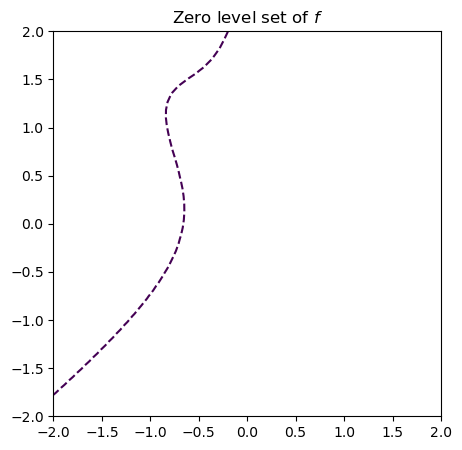

In [46]:
exp.plot_dist()

In [47]:
exp.s = 0.1
exp.weight_decay = 0
exp.neuron_lst = [20,20]
exp.n_epochs = 5000
exp.go()

Epoch 0. Training cost: 0.602185. Testing error: 0.050000
Epoch 2000. Training cost: 0.018786. Testing error: 0.030000
Epoch 4000. Training cost: 0.012444. Testing error: 0.030000
End. Training error: 0.000000. Testing error: 0.030000


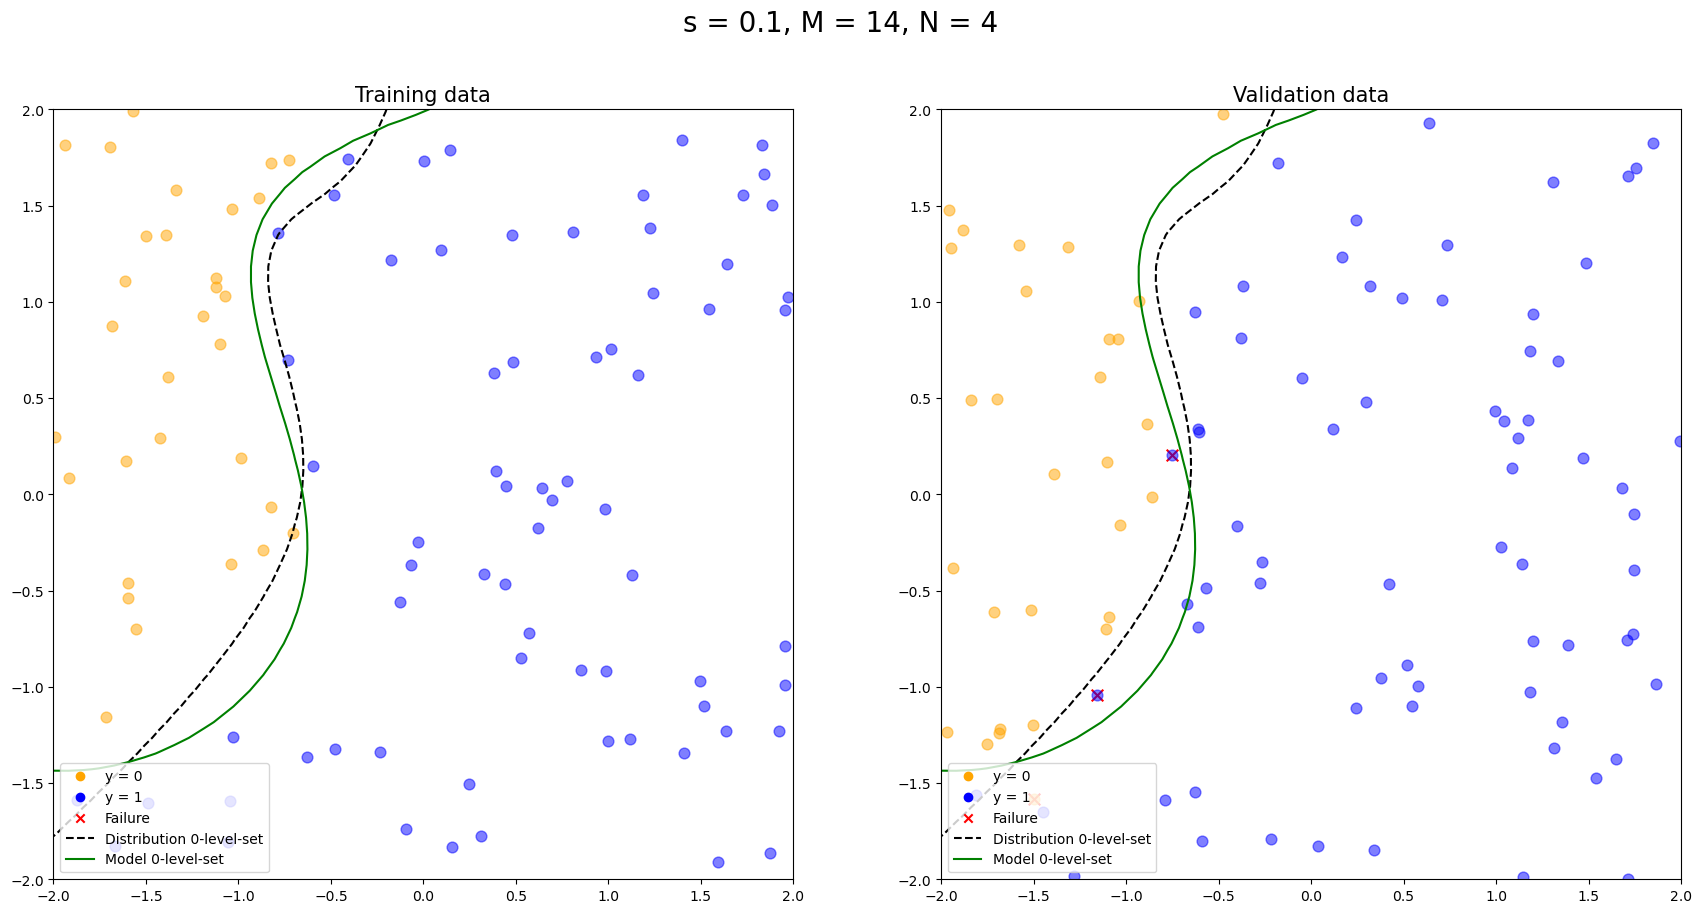

In [48]:
exp.plot_model()

#### Adding more data

In [49]:
exp.s = 0.1
exp.weight_decay = 0
exp.neuron_lst = [20,20]
exp.n_epochs = 5000 
exp.dataset_size = 500
exp.validset_size = 500
exp.go()

Epoch 0. Training cost: 0.406308. Testing error: 0.084000
Epoch 2000. Training cost: 0.032104. Testing error: 0.024000
Epoch 4000. Training cost: 0.030746. Testing error: 0.024000
End. Training error: 0.014000. Testing error: 0.024000


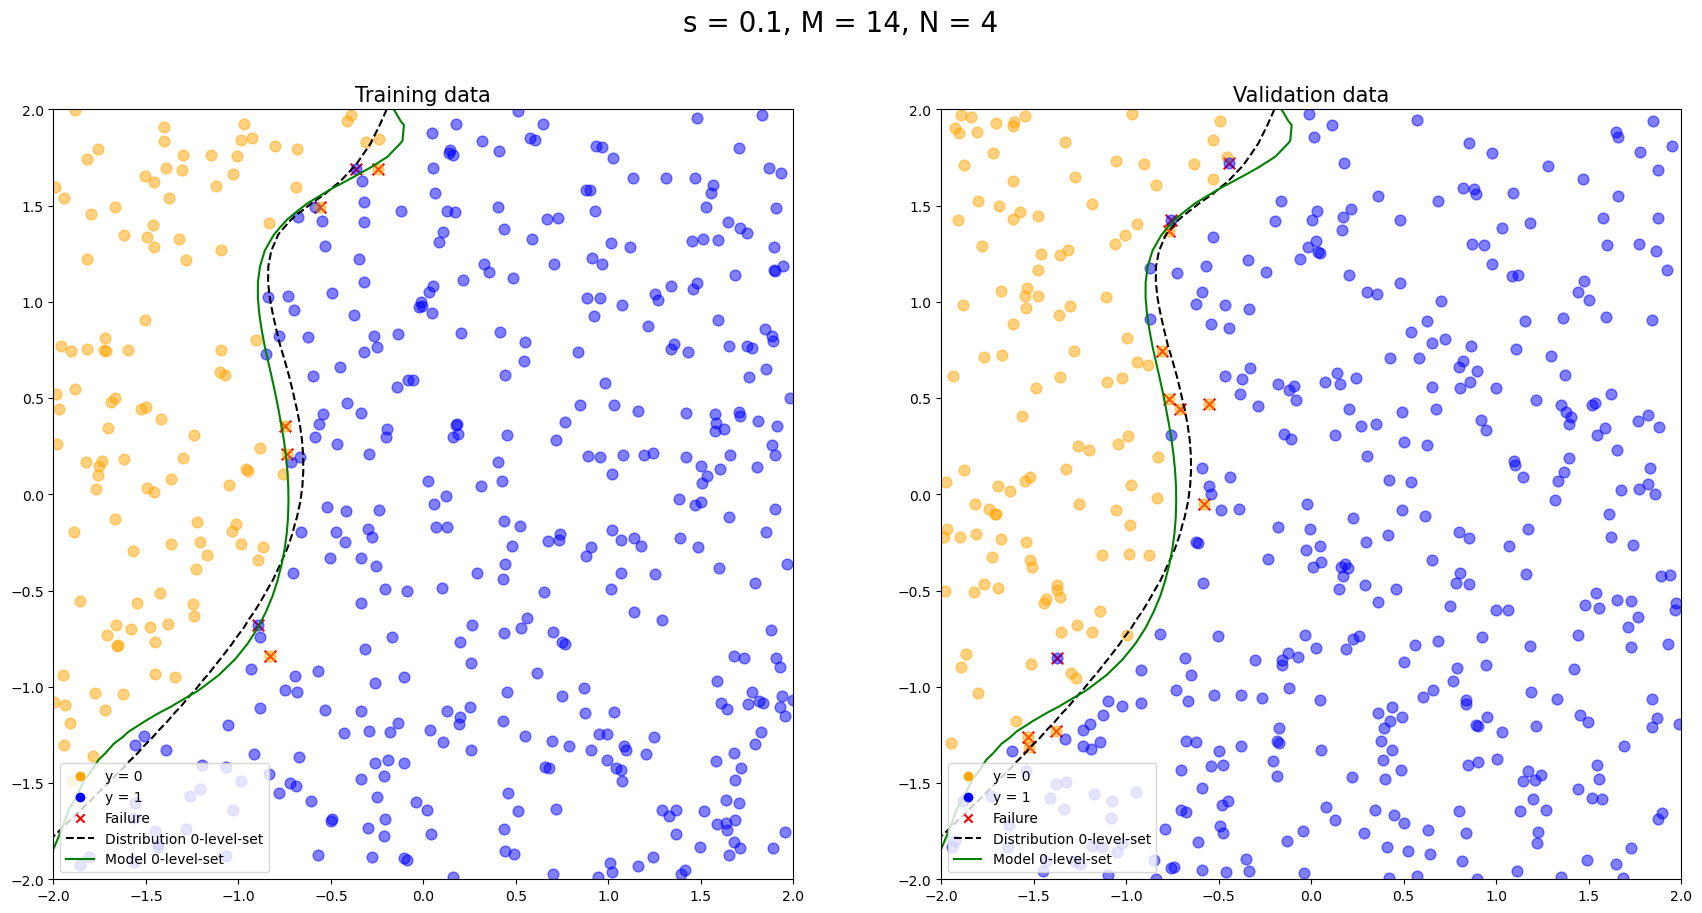

In [50]:
exp.plot_model()

##

### Adding regularisation to the NN model

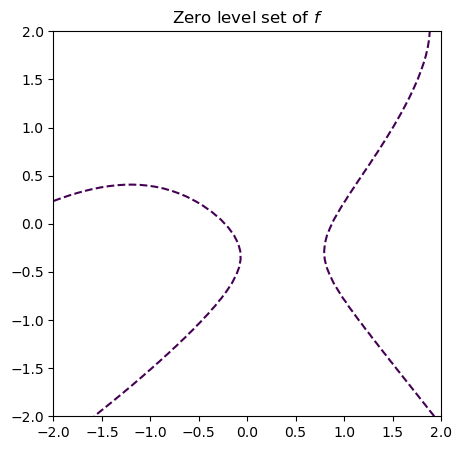

In [51]:
exp = experiment_nn(3)
exp.plot_dist()

In [52]:
exp.weight_decay = 0
exp.neuron_lst = [20,20]
exp.n_epochs = 5000 
exp.dataset_size = 500
exp.validset_size = 500
exp.go()

Epoch 0. Training cost: 0.680867. Testing error: 0.404000
Epoch 500. Training cost: 0.188098. Testing error: 0.108000
Epoch 1000. Training cost: 0.185002. Testing error: 0.102000
Epoch 1500. Training cost: 0.180941. Testing error: 0.102000
Epoch 2000. Training cost: 0.177596. Testing error: 0.104000
Epoch 2500. Training cost: 0.174242. Testing error: 0.106000
Epoch 3000. Training cost: 0.172377. Testing error: 0.108000
Epoch 3500. Training cost: 0.170639. Testing error: 0.104000
Epoch 4000. Training cost: 0.169191. Testing error: 0.110000
Epoch 4500. Training cost: 0.167549. Testing error: 0.106000
End. Training error: 0.072000. Testing error: 0.106000


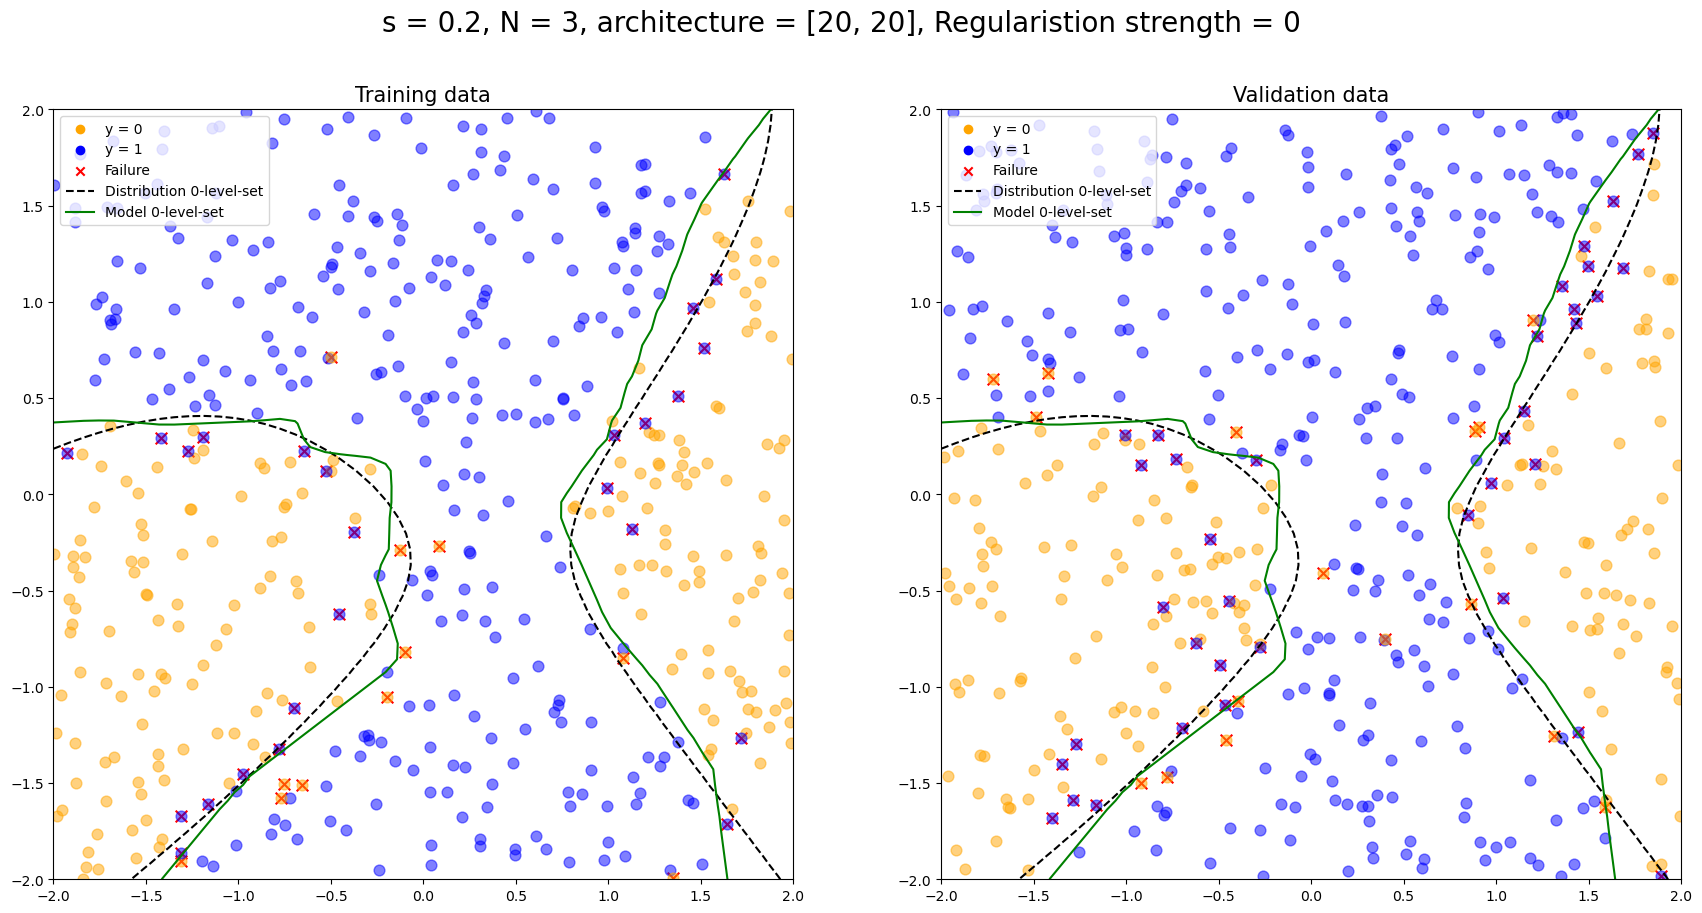

In [53]:
exp.plot_model()

In [54]:
exp.weight_decay = 0.0003
exp.neuron_lst = [20,20]
exp.n_epochs = 5000 
exp.dataset_size = 500
exp.validset_size = 500
exp.go()

Epoch 0. Training cost: 0.657379. Testing error: 0.332000
Epoch 500. Training cost: 0.200451. Testing error: 0.104000
Epoch 1000. Training cost: 0.187059. Testing error: 0.108000
Epoch 1500. Training cost: 0.176649. Testing error: 0.108000
Epoch 2000. Training cost: 0.169791. Testing error: 0.126000
Epoch 2500. Training cost: 0.172101. Testing error: 0.116000
Epoch 3000. Training cost: 0.162108. Testing error: 0.104000
Epoch 3500. Training cost: 0.164366. Testing error: 0.106000
Epoch 4000. Training cost: 0.161149. Testing error: 0.100000
Epoch 4500. Training cost: 0.170571. Testing error: 0.104000
End. Training error: 0.070000. Testing error: 0.106000


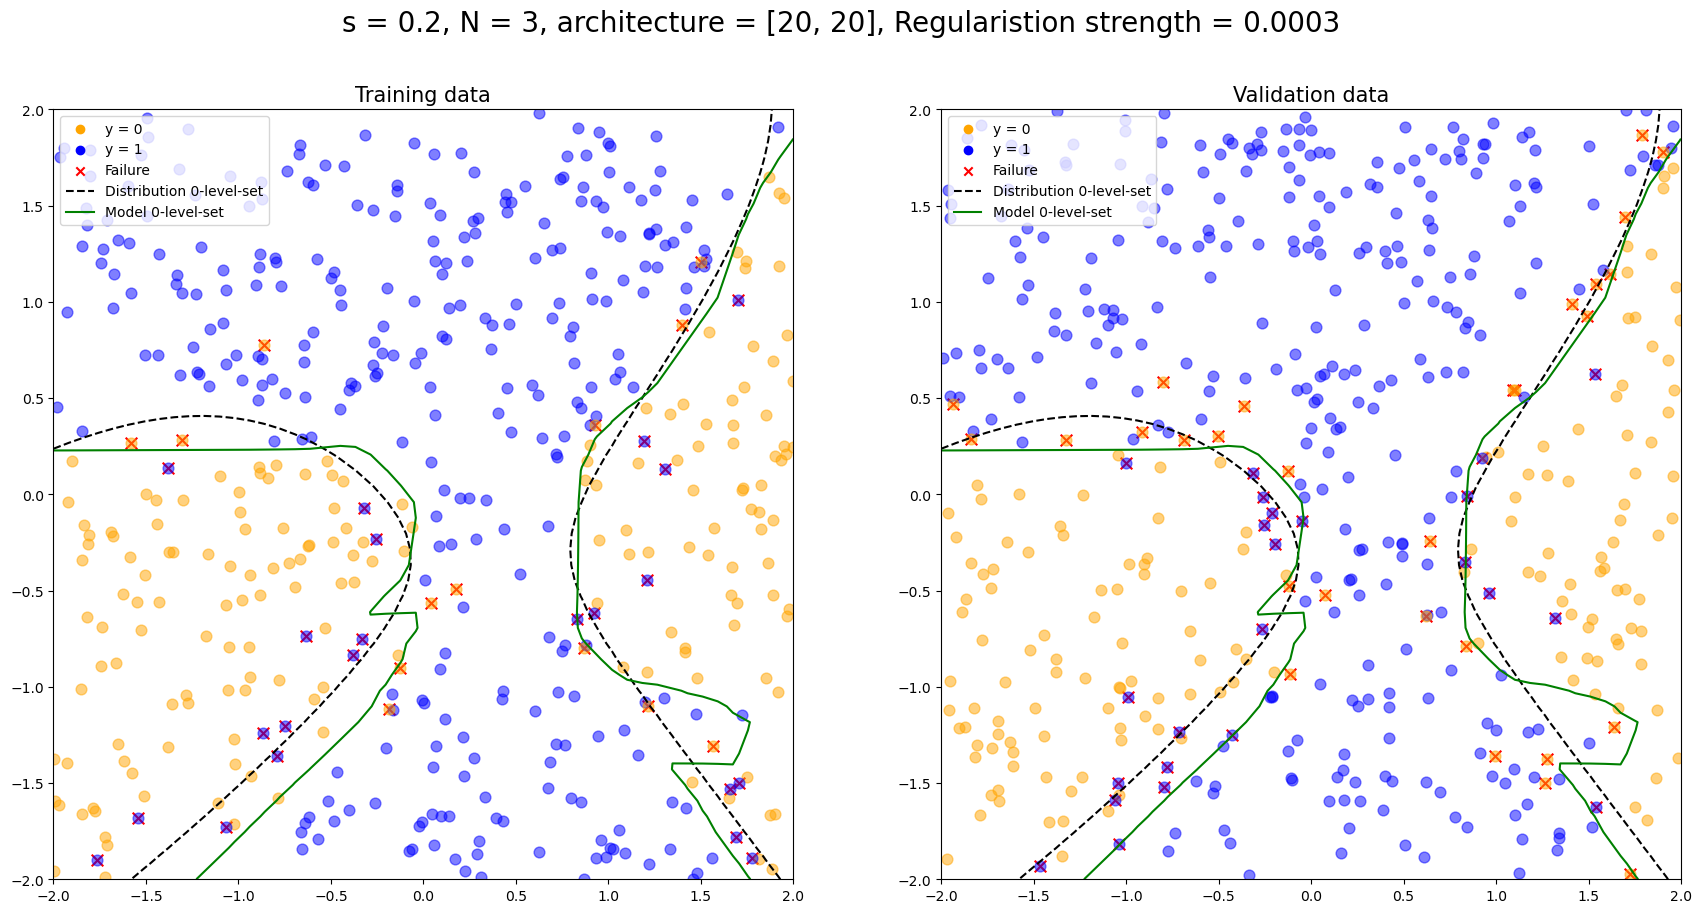

In [55]:
exp.plot_model()

In [56]:
exp.weight_decay = 0.0005
exp.neuron_lst = [20,20]
exp.n_epochs = 5000 
exp.dataset_size = 500
exp.validset_size = 500
exp.go()

Epoch 0. Training cost: 0.665167. Testing error: 0.306000
Epoch 500. Training cost: 0.209040. Testing error: 0.082000
Epoch 1000. Training cost: 0.207855. Testing error: 0.082000
Epoch 1500. Training cost: 0.207175. Testing error: 0.084000
Epoch 2000. Training cost: 0.206681. Testing error: 0.084000
Epoch 2500. Training cost: 0.206235. Testing error: 0.086000
Epoch 3000. Training cost: 0.204899. Testing error: 0.086000
Epoch 3500. Training cost: 0.203669. Testing error: 0.084000
Epoch 4000. Training cost: 0.203100. Testing error: 0.086000
Epoch 4500. Training cost: 0.201244. Testing error: 0.086000
End. Training error: 0.080000. Testing error: 0.086000


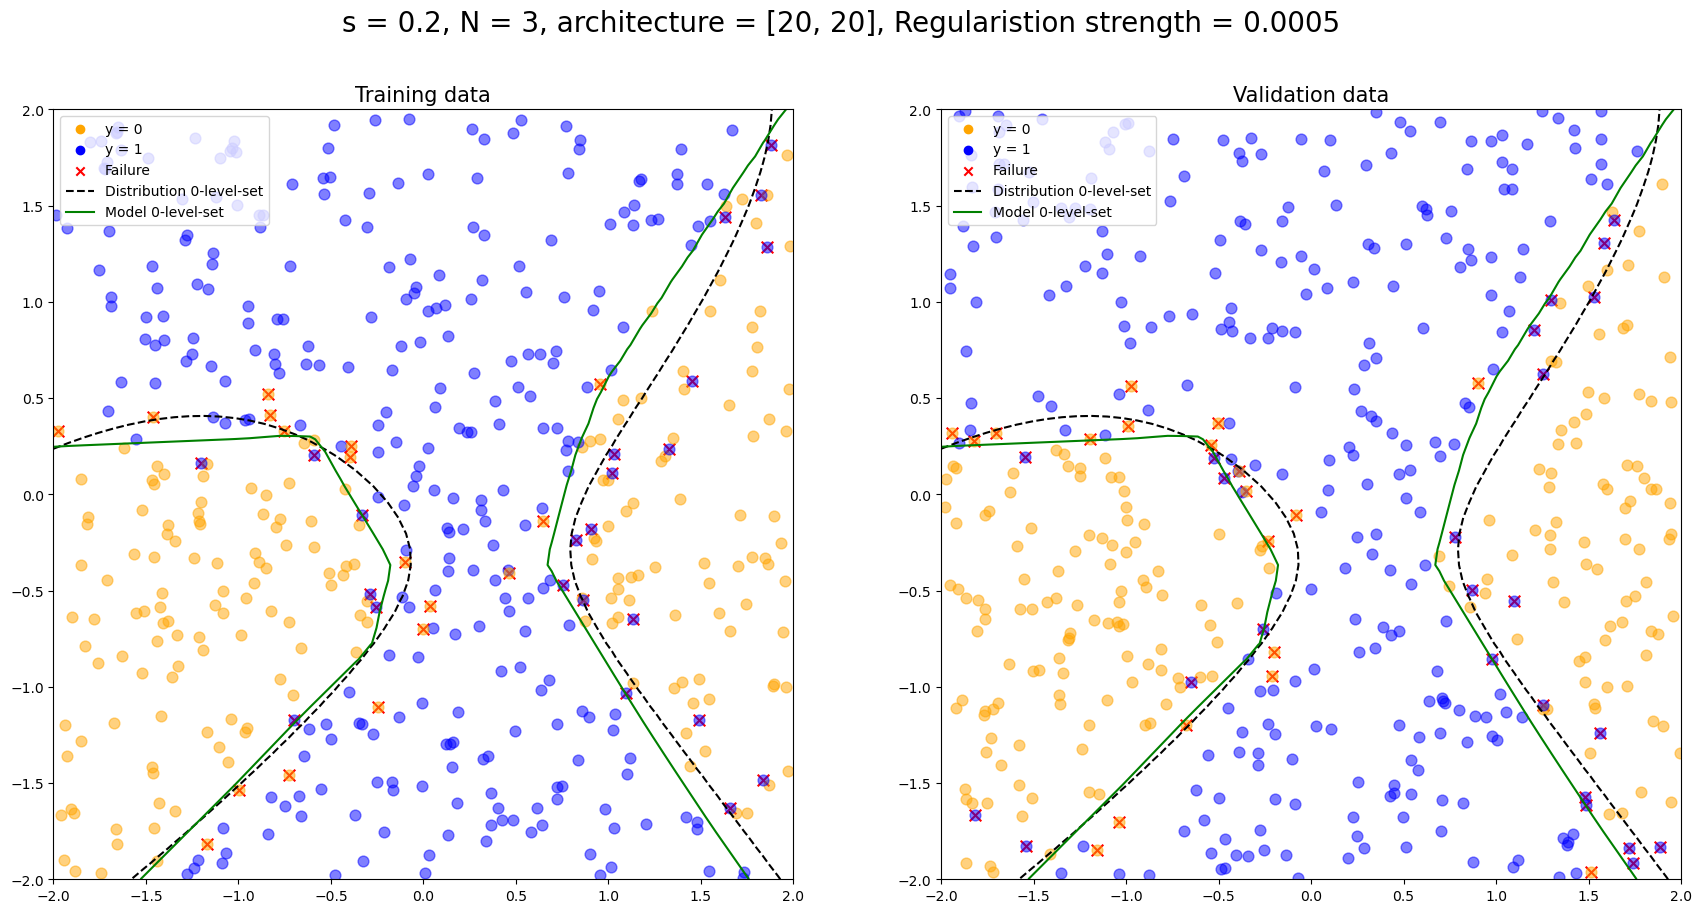

In [57]:
exp.plot_model()

In [58]:
exp.weight_decay = 0.001
exp.neuron_lst = [20,20]
exp.n_epochs = 5000 
exp.dataset_size = 500
exp.validset_size = 500
exp.go()

Epoch 0. Training cost: 0.657597. Testing error: 0.388000
Epoch 500. Training cost: 0.188862. Testing error: 0.094000
Epoch 1000. Training cost: 0.185978. Testing error: 0.094000
Epoch 1500. Training cost: 0.183888. Testing error: 0.096000
Epoch 2000. Training cost: 0.182402. Testing error: 0.094000
Epoch 2500. Training cost: 0.181815. Testing error: 0.090000
Epoch 3000. Training cost: 0.180220. Testing error: 0.092000
Epoch 3500. Training cost: 0.179215. Testing error: 0.094000
Epoch 4000. Training cost: 0.179455. Testing error: 0.092000
Epoch 4500. Training cost: 0.179150. Testing error: 0.090000
End. Training error: 0.068000. Testing error: 0.090000


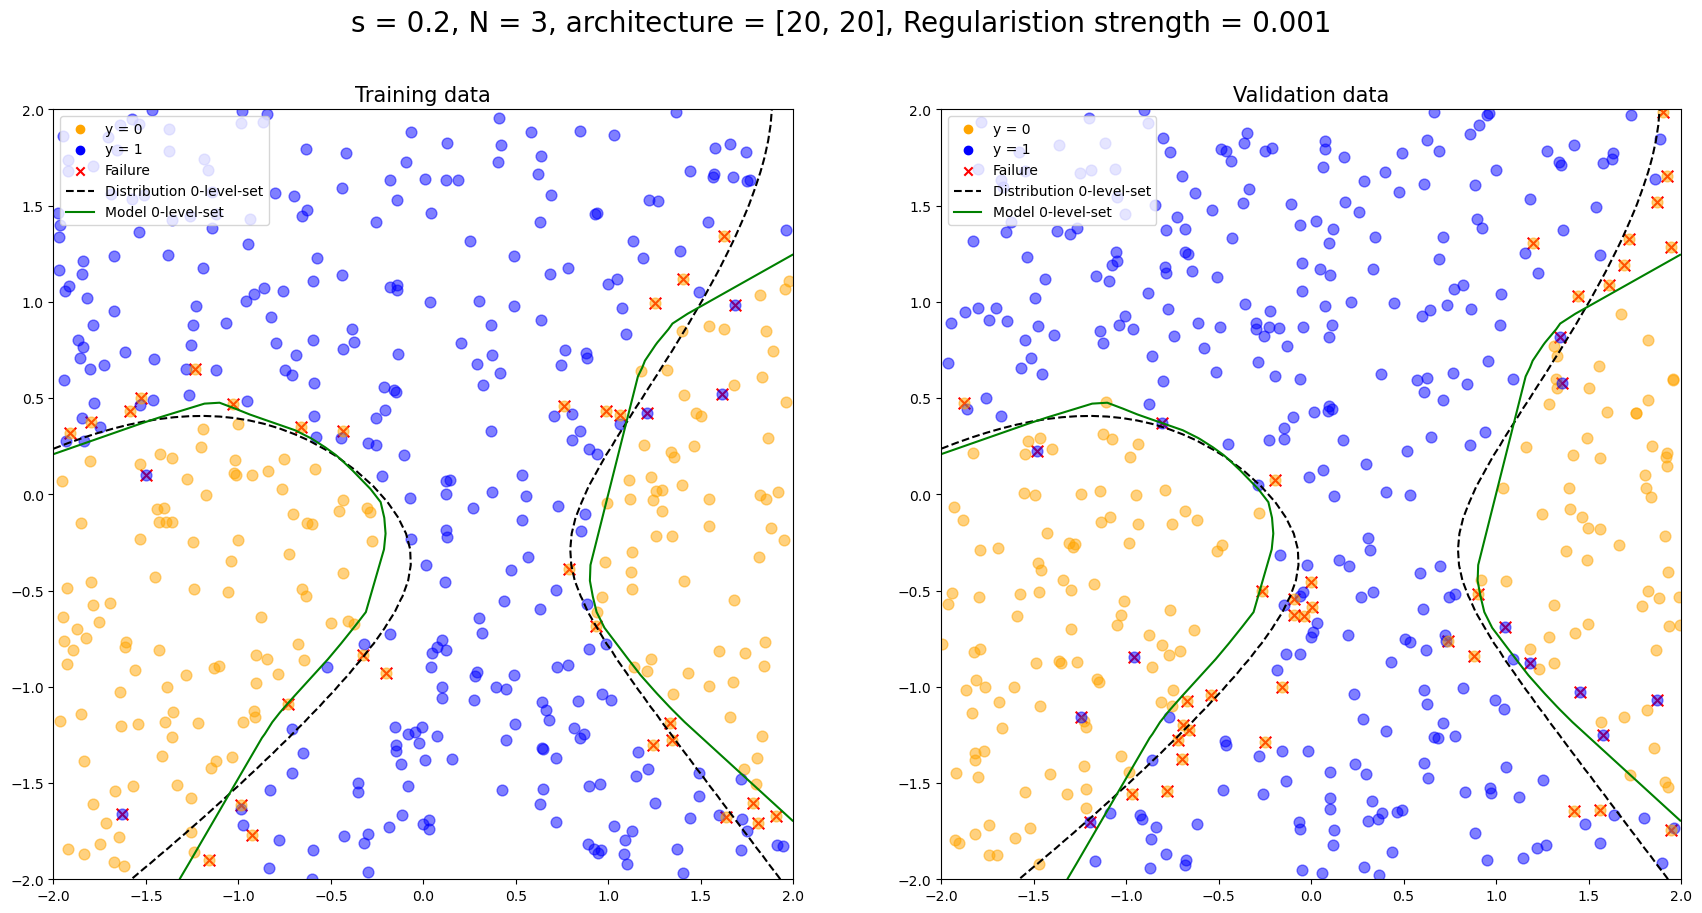

In [59]:
exp.plot_model()

In [60]:
exp.weight_decay = 0.003
exp.neuron_lst = [20,20]
exp.n_epochs = 5000 
exp.dataset_size = 500
exp.validset_size = 500
exp.go()

Epoch 0. Training cost: 0.666360. Testing error: 0.376000
Epoch 500. Training cost: 0.195137. Testing error: 0.086000
Epoch 1000. Training cost: 0.194422. Testing error: 0.088000
Epoch 1500. Training cost: 0.195098. Testing error: 0.086000
Epoch 2000. Training cost: 0.195035. Testing error: 0.086000
Epoch 2500. Training cost: 0.194365. Testing error: 0.086000
Epoch 3000. Training cost: 0.194096. Testing error: 0.086000
Epoch 3500. Training cost: 0.193400. Testing error: 0.086000
Epoch 4000. Training cost: 0.193194. Testing error: 0.086000
Epoch 4500. Training cost: 0.192944. Testing error: 0.090000
End. Training error: 0.078000. Testing error: 0.088000


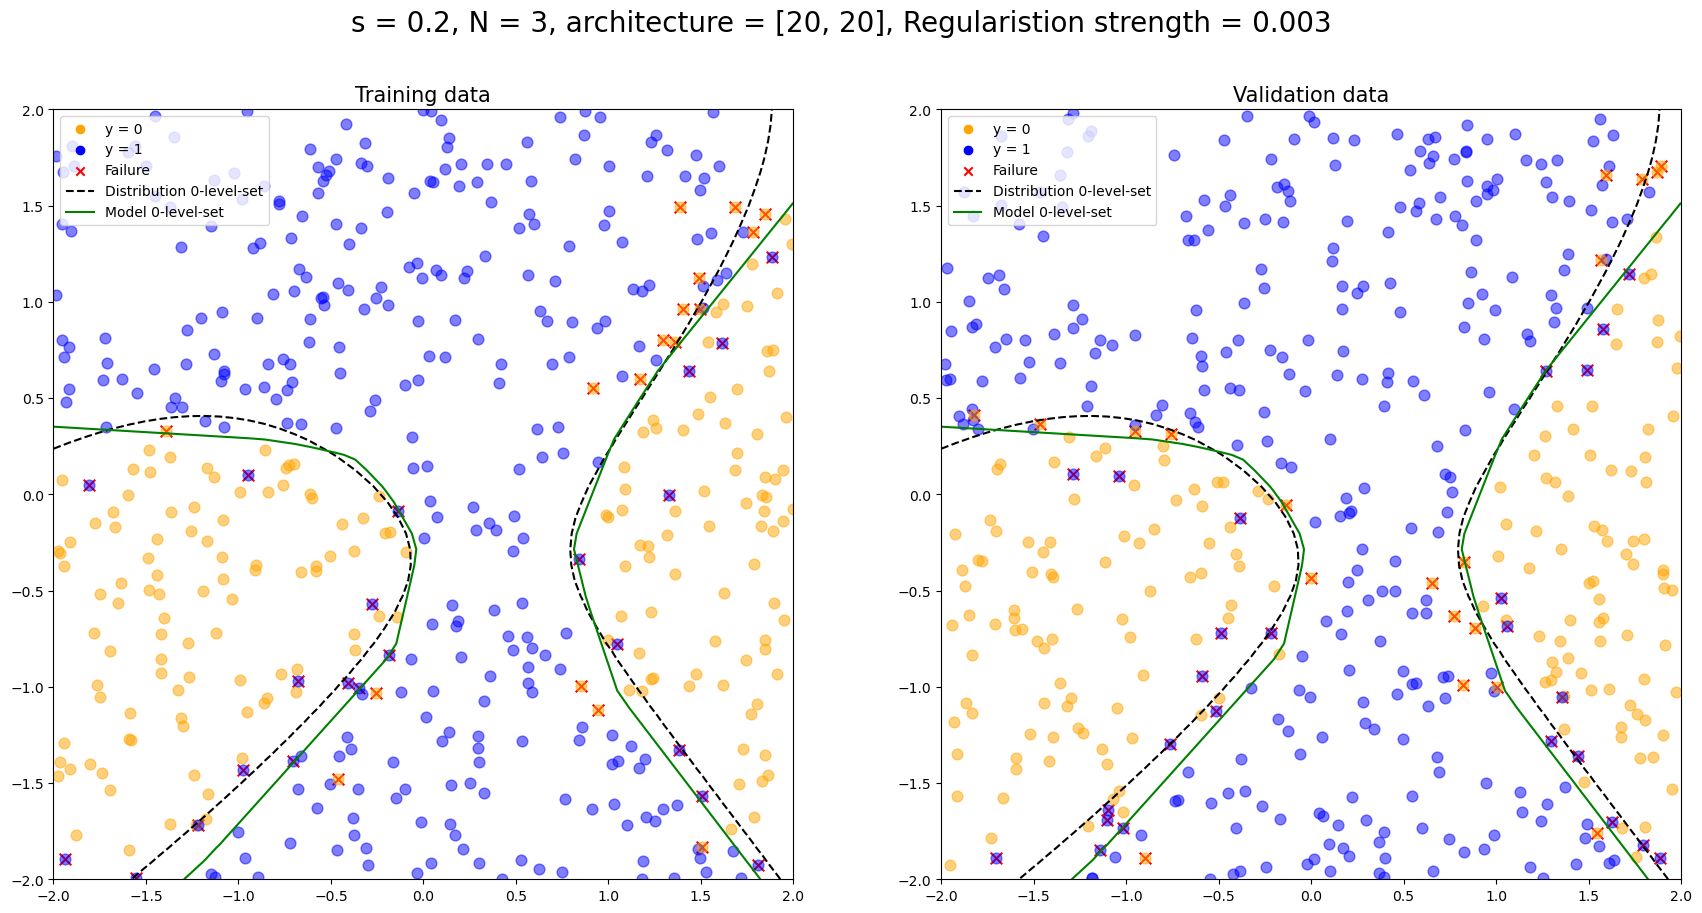

In [61]:
exp.plot_model()

In [62]:
exp.weight_decay = 0.01
exp.neuron_lst = [20,20]
exp.n_epochs = 5000 
exp.dataset_size = 500
exp.validset_size = 500
exp.go()

Epoch 0. Training cost: 0.673915. Testing error: 0.372000
Epoch 500. Training cost: 0.248282. Testing error: 0.092000
Epoch 1000. Training cost: 0.249691. Testing error: 0.098000
Epoch 1500. Training cost: 0.250053. Testing error: 0.092000
Epoch 2000. Training cost: 0.250971. Testing error: 0.092000
Epoch 2500. Training cost: 0.251231. Testing error: 0.092000
Epoch 3000. Training cost: 0.251405. Testing error: 0.092000
Epoch 3500. Training cost: 0.251323. Testing error: 0.092000
Epoch 4000. Training cost: 0.251460. Testing error: 0.092000
Epoch 4500. Training cost: 0.251330. Testing error: 0.092000
End. Training error: 0.100000. Testing error: 0.092000


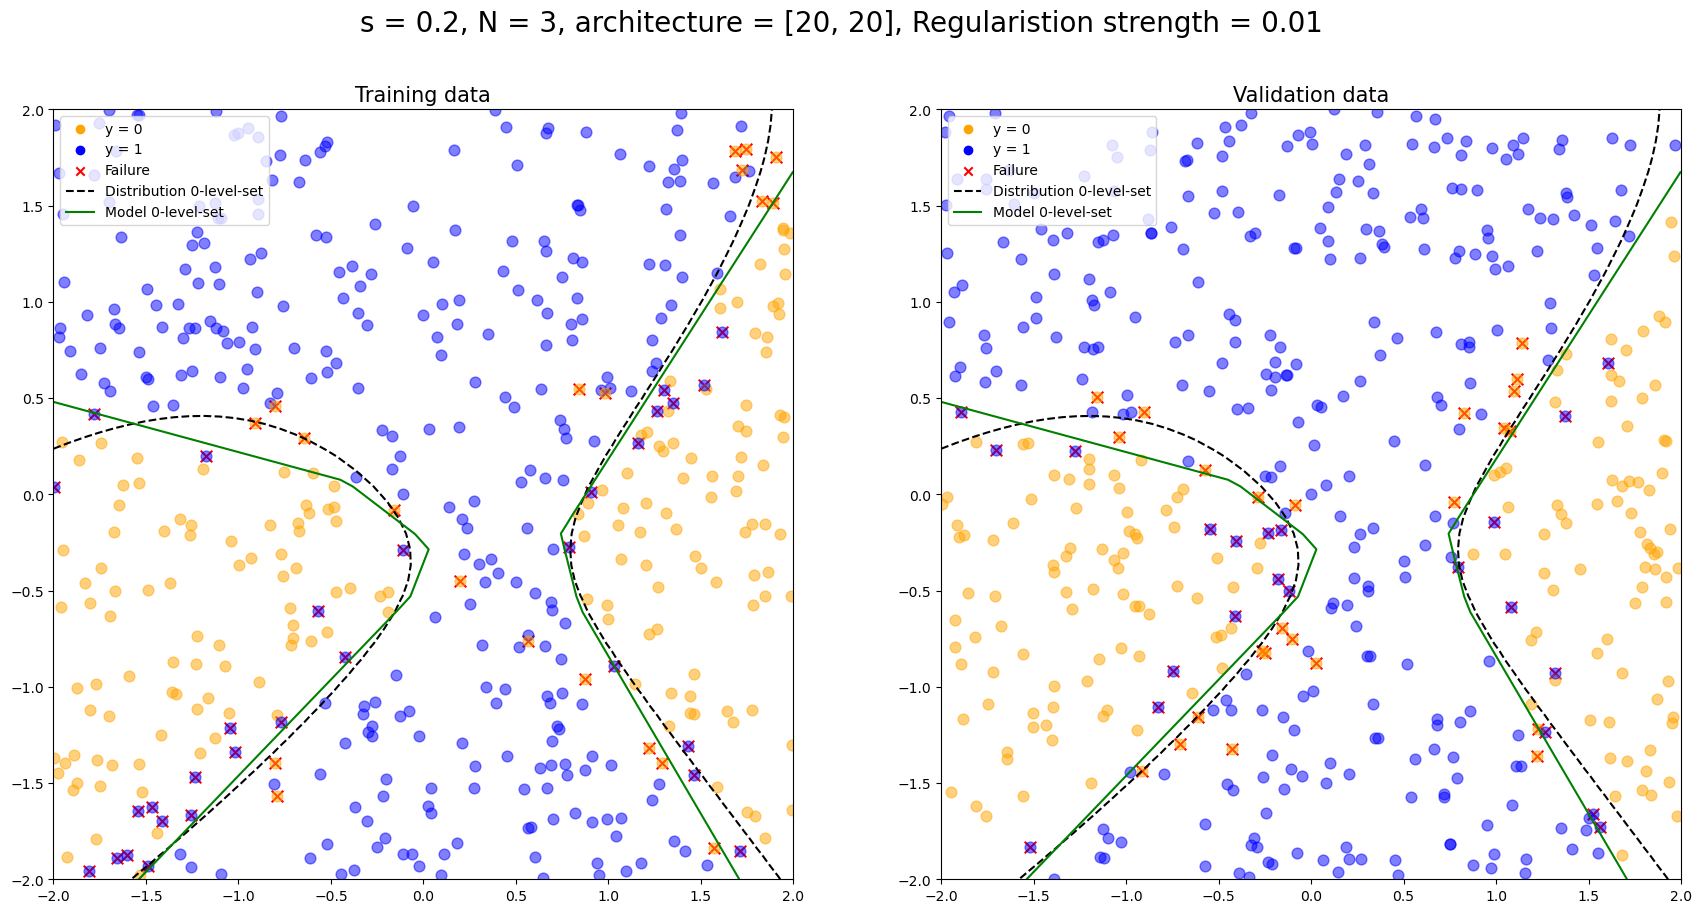

In [63]:
exp.plot_model()

In [64]:
exp.weight_decay = 0.03
exp.neuron_lst = [20,20]
exp.n_epochs = 5000 
exp.dataset_size = 500
exp.validset_size = 500
exp.go()

Epoch 0. Training cost: 0.650073. Testing error: 0.352000
Epoch 500. Training cost: 0.349352. Testing error: 0.110000
Epoch 1000. Training cost: 0.349345. Testing error: 0.112000
Epoch 1500. Training cost: 0.349352. Testing error: 0.110000
Epoch 2000. Training cost: 0.349345. Testing error: 0.112000
Epoch 2500. Training cost: 0.349352. Testing error: 0.110000
Epoch 3000. Training cost: 0.349345. Testing error: 0.112000
Epoch 3500. Training cost: 0.349352. Testing error: 0.110000
Epoch 4000. Training cost: 0.349345. Testing error: 0.112000
Epoch 4500. Training cost: 0.349352. Testing error: 0.110000
End. Training error: 0.142000. Testing error: 0.110000


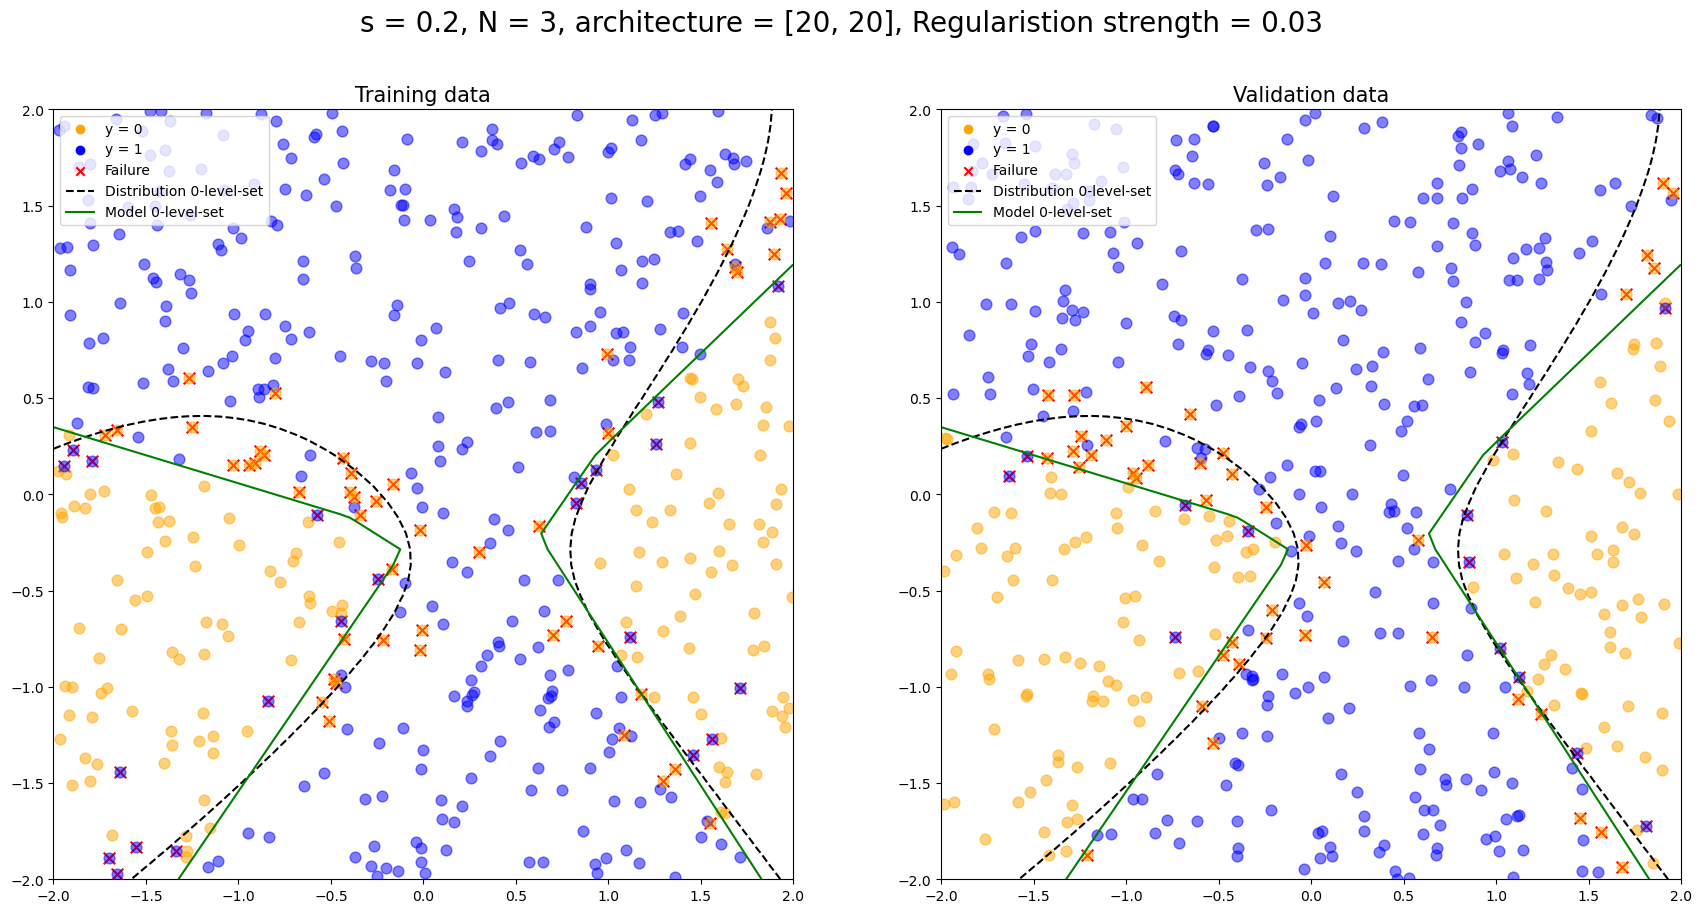

In [65]:
exp.plot_model()

In [66]:
exp.weight_decay = 0.1
exp.neuron_lst = [20,20]
exp.n_epochs = 5000 
exp.dataset_size = 500
exp.validset_size = 500
exp.go()

Epoch 0. Training cost: 0.668022. Testing error: 0.340000
Epoch 500. Training cost: 0.666961. Testing error: 0.340000
Epoch 1000. Training cost: 0.666961. Testing error: 0.340000
Epoch 1500. Training cost: 0.666961. Testing error: 0.340000
Epoch 2000. Training cost: 0.666961. Testing error: 0.340000
Epoch 2500. Training cost: 0.666961. Testing error: 0.340000
Epoch 3000. Training cost: 0.666961. Testing error: 0.340000
Epoch 3500. Training cost: 0.666961. Testing error: 0.340000
Epoch 4000. Training cost: 0.666961. Testing error: 0.340000
Epoch 4500. Training cost: 0.666961. Testing error: 0.340000
End. Training error: 0.380000. Testing error: 0.340000


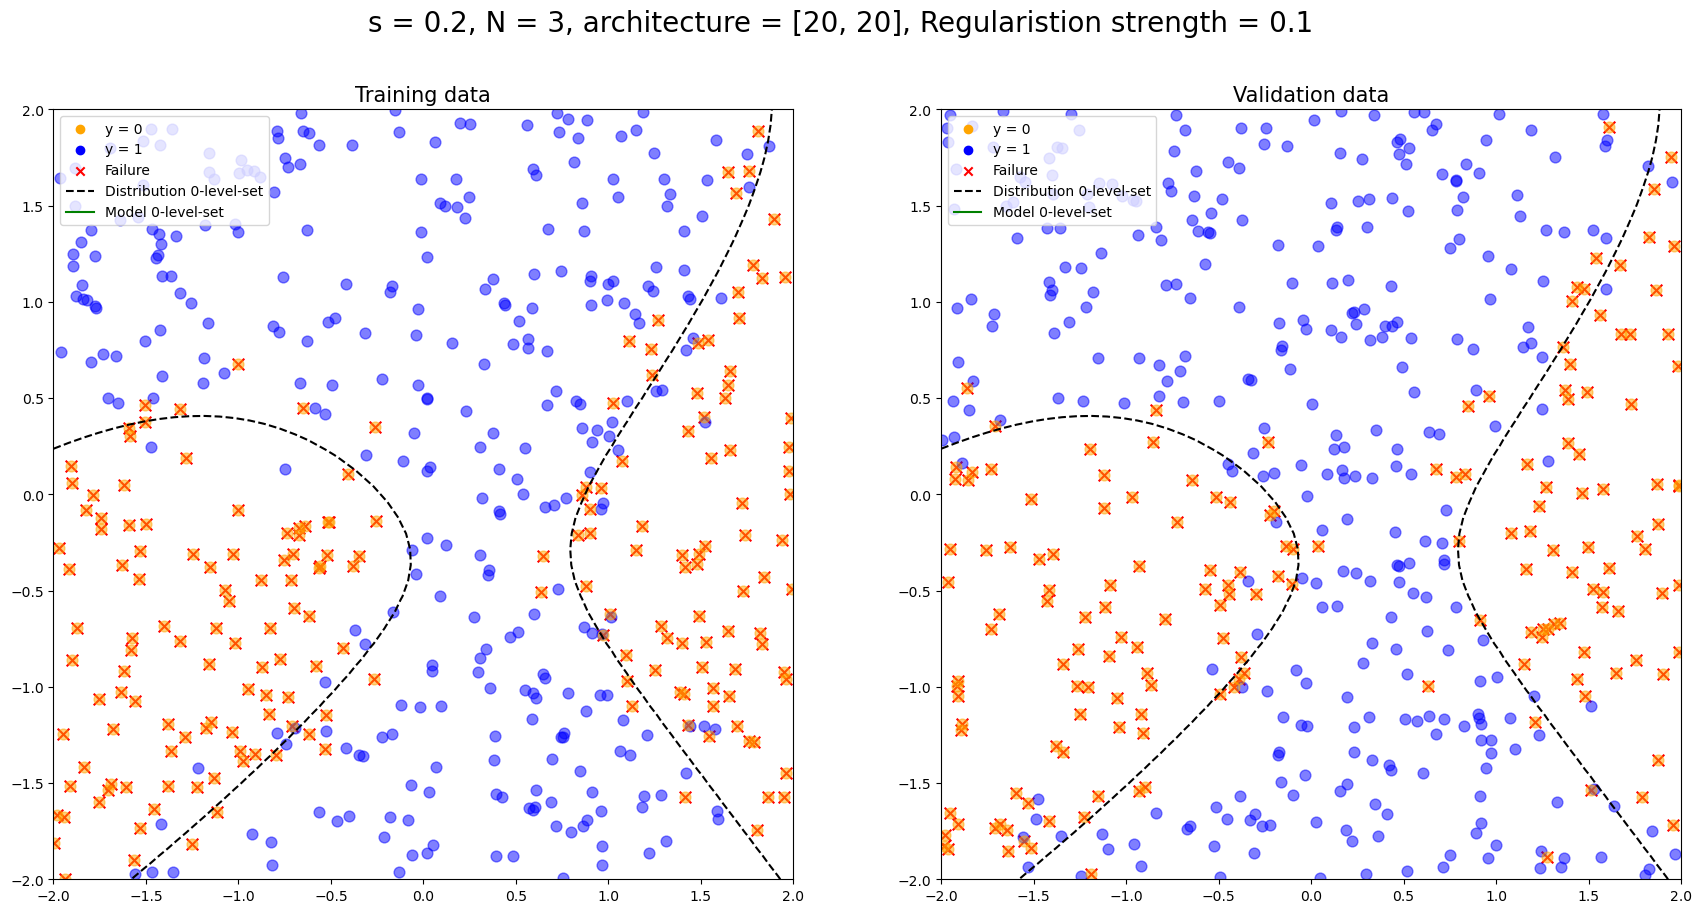

In [67]:
exp.plot_model()